In [1]:
import itertools as it
import os

from cliffs_delta import cliffs_delta
from iterpop import iterpop as ip
import matplotlib as mpl
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp

from pylib import describe_effect


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: fv-az1567-474
interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
nbcellexec: null
nbname: spatial-nuissance-phylometrics
nbpath: /home/runner/work/hstrat-evolutionary-inference/hstrat-evolutionary-inference/binder/simple-splayed/spatial-nuissance-phylometrics.ipynb
revision: null
session: d3301d09-cc9a-4aa7-9fa5-db825a940311
timestamp: 2024-05-26T00:39:54Z00:00


IPython==8.13.0
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.12.1
teeplot==1.0.1
re==2.2.1
comm==0.2.2
logging==0.5.1.2
psutil==5.9.8
zmq==24.0.1
json==2.0.9
ipykernel==6.29.3


In [3]:
df = pd.read_csv("https://osf.io/xd95a/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


d5fa12f6738c655


a  epoch                  mut_distn  \
0       collapsed-phylogeny      7  np.random.standard_normal   
1       collapsed-phylogeny      7  np.random.standard_normal   
2       collapsed-phylogeny      7  np.random.standard_normal   
3       collapsed-phylogeny      7  np.random.standard_normal   
4       collapsed-phylogeny      7  np.random.standard_normal   
...                     ...    ...                        ...   
104995   reconstructed-tree      2  np.random.standard_normal   
104996   reconstructed-tree      2  np.random.standard_normal   
104997   reconstructed-tree      2  np.random.standard_normal   
104998   reconstructed-tree      2  np.random.standard_normal   
104999   reconstructed-tree      2  np.random.standard_normal   

        num_generations  num_islands  num_niches  p_island_migration  \
0                 32768         1024           4                0.01   
1                 32768         1024           4                0.01   
2                 32768         1024           4                0.01   
3                 32768         1024           4                0.01   
4                 32768         1024           4                0.01   
...                 ...          ...         ...                 ...   
104995            32768            1           4                0.01   
104996            32768            1           4                0.01   
104997            32768            1           4                0.01   
104998            32768            1           4                0.01   
104999            32768            1           4                0.01   

        p_niche_invasion  population_size  replicate  ...  \
0           3.051758e-06            32768         20  ...   
1           3.051758e-06            32768          4  ...   
2           3.051758e-06            32768         41  ...   
3           3.051758e-06            32768         47  ...   
4           3.051758e-06            32768         15  ...   
...                  ...              ...        ...  ...   
104995      3.051758e-08            32768         10  ...   
104996      3.051758e-08            32768         16  ...   
104997      3.051758e-08            32768          1  ...   
104998      3.051758e-08            32768         10  ...   
104999      3.051758e-08            32768         36  ...   

        variance_pairwise_distance  variance_pairwise_distance_branch_only  \
0                        31.886538                               31.886538   
1                        28.357566                               28.357566   
2                        28.516943                               28.516943   
3                        30.233129                               30.233129   
4                        29.675131                               29.675131   
...                            ...                                     ...   
104995                   28.560595                               28.560595   
104996                   20.627240                               20.627240   
104997                  114.169456                              114.169456   
104998                   36.528638                               36.528638   
104999                   34.498647                               34.498647   

        mrca_depth  sackin_index mean_evolutionary_distinctiveness  \
0                1        609638                         78.882446   
1                1        588616                         81.707306   
2                0        592371                         83.217377   
3                0        586736                         86.538544   
4                1        600764                         76.277557   
...            ...           ...                               ...   
104995           1          3547                         99.163609   
104996           0          3331                       1893.146789   
104997           1        821866                          5.744125   
104998    

In [4]:
# filter out incomplete sets of replicates
df1 = df[
    df["a"] == "reconstructed-tree"
].groupby(
    [
        'epoch',
        'mut_distn',
        'num_islands',
        'num_niches',
        'p_island_migration',
        'p_niche_invasion',
        'population_size',
        'tournament_size',
        'treatment',
        'a',
        'resolution',
        'subsampling-fraction',
        'trie-postprocess',
    ],
    dropna=False,
).filter(
    lambda x: len(x) == 50,
).reset_index(drop=True)

df1["a"].unique()


array(['reconstructed-tree'], dtype=object)

In [5]:
# filter out incomplete sets of replicates
df2 = df[
    df["a"] == "collapsed-phylogeny"
].groupby(
    [
        'epoch',
        'mut_distn',
        'num_islands',
        'num_niches',
        'p_island_migration',
        'p_niche_invasion',
        'population_size',
        'tournament_size',
        'treatment',
        'a',
    ],
    dropna=False,
).filter(
    lambda x: len(x) == 50,
).reset_index(drop=True)

df2["a"].unique()


array(['collapsed-phylogeny'], dtype=object)

In [6]:
df = pd.concat([df1, df2], ignore_index=True)
df


a  epoch              mut_distn  num_generations  \
0        reconstructed-tree      7  np.random.exponential            32768   
1        reconstructed-tree      7  np.random.exponential            32768   
2        reconstructed-tree      7  np.random.exponential            32768   
3        reconstructed-tree      7  np.random.exponential            32768   
4        reconstructed-tree      7  np.random.exponential            32768   
...                     ...    ...                    ...              ...   
104995  collapsed-phylogeny      2  np.random.exponential            32768   
104996  collapsed-phylogeny      2  np.random.exponential            32768   
104997  collapsed-phylogeny      2  np.random.exponential            32768   
104998  collapsed-phylogeny      2  np.random.exponential            32768   
104999  collapsed-phylogeny      2  np.random.exponential            32768   

        num_islands  num_niches  p_island_migration  p_niche_invasion  \
0              1024           4                0.01      3.051758e-08   
1              1024           4                0.01      3.051758e-08   
2              1024           4                0.01      3.051758e-08   
3              1024           4                0.01      3.051758e-08   
4              1024           4                0.01      3.051758e-08   
...             ...         ...                 ...               ...   
104995         1024           4                0.01      3.051758e-06   
104996         1024           4                0.01      3.051758e-06   
104997         1024           4                0.01      3.051758e-06   
104998         1024           4                0.01      3.051758e-06   
104999         1024           4                0.01      3.051758e-06   

        population_size  replicate  ...  variance_pairwise_distance  \
0                 32768         46  ...                   30.592668   
1                 32768         30  ...                   25.488540   
2                 32768         32  ...                   16.790542   
3                 32768          1  ...                   25.969854   
4                 32768         17  ...                   20.596500   
...                 ...        ...  ...                         ...   
104995            32768         35  ...                   31.222858   
104996            32768         30  ...                   33.379170   
104997            32768         49  ...                   36.683984   
104998            32768         42  ...                   27.494275   
104999            32768         13  ...                   30.929621   

        variance_pairwise_distance_branch_only  mrca_depth  sackin_index  \
0                                    30.592668           0        601771   
1                                    25.488540           0        576666   
2                                    16.790542           0          3177   
3                                    25.969854           0        579202   
4                                    20.596500           0          3242   
...                                        ...         ...           ...   
104995                               31.222858           0        597571   
104996                               33.379170           0        593800   
104997                               36.683984           0        600262   
104998                               27.494275           0        580657   
104999                               30.929621           0        585228   

       mean_evolutionary_distinctiveness sum_evolutionary_distinctiveness  \
0                             118.941956                     3.897490e+06   
1                             123.441128                     4.044919e+06   
2                            8880.562691                     2.903944e+06   
3                             122.678925                     4.019943e+06   
4                           10902.110092                     

In [7]:
# phylometrics whittled down to descriptive, non-redundant set
df["colless-like index"] = df["colless_like_index"]
df["mean pairwise distance"] = df["mean_pairwise_distance"]
df["sum pairwise distance"] = df["sum_distance"]
df["mean evolutionary distinctiveness"] = df[
    "mean_evolutionary_distinctiveness"
]

phylometrics = [
    #     'diversity',
    "colless-like index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean pairwise distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "sum pairwise distance",
    # "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean evolutionary distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [8]:
methodological_variables = [
    "resolution",
]


In [9]:
evolutionary_variables = [
    "num_niches",
]


In [10]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [11]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
    "tournament_size",  # only use 2
    "num_islands",  # only use 1024
]


In [12]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & (df["tournament_size"] == 2)
    & (df["num_islands"] == 1024)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1, excluded_variable

df


a  epoch              mut_distn  num_generations  \
3        reconstructed-tree      7  np.random.exponential            32768   
13       reconstructed-tree      7  np.random.exponential            32768   
17       reconstructed-tree      7  np.random.exponential            32768   
36       reconstructed-tree      7  np.random.exponential            32768   
39       reconstructed-tree      7  np.random.exponential            32768   
...                     ...    ...                    ...              ...   
104995  collapsed-phylogeny      2  np.random.exponential            32768   
104996  collapsed-phylogeny      2  np.random.exponential            32768   
104997  collapsed-phylogeny      2  np.random.exponential            32768   
104998  collapsed-phylogeny      2  np.random.exponential            32768   
104999  collapsed-phylogeny      2  np.random.exponential            32768   

        num_islands  num_niches  p_island_migration  p_niche_invasion  \
3              1024           4                0.01      3.051758e-08   
13             1024           4                0.01      3.051758e-08   
17             1024           4                0.01      3.051758e-08   
36             1024           4                0.01      3.051758e-08   
39             1024           4                0.01      3.051758e-08   
...             ...         ...                 ...               ...   
104995         1024           4                0.01      3.051758e-06   
104996         1024           4                0.01      3.051758e-06   
104997         1024           4                0.01      3.051758e-06   
104998         1024           4                0.01      3.051758e-06   
104999         1024           4                0.01      3.051758e-06   

        population_size  replicate  ...  mean_evolutionary_distinctiveness  \
3                 32768          1  ...                         122.678925   
13                32768         36  ...                         127.564987   
17                32768         28  ...                         135.647598   
36                32768         29  ...                         109.768127   
39                32768         13  ...                         122.617172   
...                 ...        ...  ...                                ...   
104995            32768         35  ...                          62.567078   
104996            32768         30  ...                          54.291748   
104997            32768         49  ...                          61.928589   
104998            32768         42  ...                          65.404114   
104999            32768         13  ...                          61.885101   

        sum_evolutionary_distinctiveness  \
3                              4019943.0   
13                             4180049.5   
17                             4444900.5   
36                             3596882.0   
39                             4017919.5   
...                                  ...   
104995                         2050198.0   
104996                         1779032.0   
104997                         2029276.0   
104998                         2143162.0   
104999                         2027851.0   

        variance_evolutionary_distinctiveness  resolution  \
3                                 3007.903179        10.0   
13                                3722.405359       100.0   
17                                3748.945329        30.0   
36                                2150.734783       100.0   
39                                3744.830484       100.0   
...                                       ...         ...   
104995                             699.189837         NaN   
104996                             501.593774         NaN   
104997                            1052.942164         NaN   
104998                             870.762049         NaN   
104999                             835.205725         NaN   

       subsam

In [13]:
# exclude extraneous variable values
df = df[(df["a"] != "consolidated-phylogeny")].copy()

df


a  epoch              mut_distn  num_generations  \
3        reconstructed-tree      7  np.random.exponential            32768   
13       reconstructed-tree      7  np.random.exponential            32768   
17       reconstructed-tree      7  np.random.exponential            32768   
36       reconstructed-tree      7  np.random.exponential            32768   
39       reconstructed-tree      7  np.random.exponential            32768   
...                     ...    ...                    ...              ...   
104995  collapsed-phylogeny      2  np.random.exponential            32768   
104996  collapsed-phylogeny      2  np.random.exponential            32768   
104997  collapsed-phylogeny      2  np.random.exponential            32768   
104998  collapsed-phylogeny      2  np.random.exponential            32768   
104999  collapsed-phylogeny      2  np.random.exponential            32768   

        num_islands  num_niches  p_island_migration  p_niche_invasion  \
3              1024           4                0.01      3.051758e-08   
13             1024           4                0.01      3.051758e-08   
17             1024           4                0.01      3.051758e-08   
36             1024           4                0.01      3.051758e-08   
39             1024           4                0.01      3.051758e-08   
...             ...         ...                 ...               ...   
104995         1024           4                0.01      3.051758e-06   
104996         1024           4                0.01      3.051758e-06   
104997         1024           4                0.01      3.051758e-06   
104998         1024           4                0.01      3.051758e-06   
104999         1024           4                0.01      3.051758e-06   

        population_size  replicate  ...  mean_evolutionary_distinctiveness  \
3                 32768          1  ...                         122.678925   
13                32768         36  ...                         127.564987   
17                32768         28  ...                         135.647598   
36                32768         29  ...                         109.768127   
39                32768         13  ...                         122.617172   
...                 ...        ...  ...                                ...   
104995            32768         35  ...                          62.567078   
104996            32768         30  ...                          54.291748   
104997            32768         49  ...                          61.928589   
104998            32768         42  ...                          65.404114   
104999            32768         13  ...                          61.885101   

        sum_evolutionary_distinctiveness  \
3                              4019943.0   
13                             4180049.5   
17                             4444900.5   
36                             3596882.0   
39                             4017919.5   
...                                  ...   
104995                         2050198.0   
104996                         1779032.0   
104997                         2029276.0   
104998                         2143162.0   
104999                         2027851.0   

        variance_evolutionary_distinctiveness  resolution  \
3                                 3007.903179        10.0   
13                                3722.405359       100.0   
17                                3748.945329        30.0   
36                                2150.734783       100.0   
39                                3744.830484       100.0   
...                                       ...         ...   
104995                             699.189837         NaN   
104996                             501.593774         NaN   
104997                            1052.942164         NaN   
104998                             870.762049         NaN   
104999                             835.205725         NaN   

       subsam

In [14]:
df["num_niches"].unique()


array([4, 1, 8])

In [15]:
df["num_islands"].unique()


array([1024])

In [16]:
df["tournament_size"].unique()


array([2])

In [17]:
df["a"].unique()


array(['reconstructed-tree', 'collapsed-phylogeny'], dtype=object)

In [18]:
df["regime"] = df.apply(
    lambda row: {
        (1024, 1, 3.0517578125e-08): "plain",
        (1024, 4, 3.0517578125e-08): "ecology",
        (1024, 4, 3.0517578125e-06): "weak ecology",
        (1024, 8, 3.0517578125e-08): "rich ecology",
    }.get(
        tuple(row[["num_islands", "num_niches", "p_niche_invasion"]]),
        np.nan,  # default
    ),
    axis="columns",
)
df["regime"].unique()


array(['ecology', 'plain', 'weak ecology', 'rich ecology'], dtype=object)

In [19]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['weak ecology', 'ecology', 'plain', 'rich ecology'], dtype=object)

# perfect phylogenetic data


In [20]:
melted_df = df[(df["a"] == "collapsed-phylogeny")].melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


num_niches  resolution  epoch                  mut_distn        regime  \
0              4         NaN      7  np.random.standard_normal  weak ecology   
1              4         NaN      7  np.random.standard_normal  weak ecology   
2              4         NaN      7  np.random.standard_normal  weak ecology   
3              4         NaN      7  np.random.standard_normal  weak ecology   
4              4         NaN      7  np.random.standard_normal  weak ecology   
...          ...         ...    ...                        ...           ...   
4795           4         NaN      2      np.random.exponential  weak ecology   
4796           4         NaN      2      np.random.exponential  weak ecology   
4797           4         NaN      2      np.random.exponential  weak ecology   
4798           4         NaN      2      np.random.exponential  weak ecology   
4799           4         NaN      2      np.random.exponential  weak ecology   

                               variable          value  \
0                    colless-like index  315335.603640   
1                    colless-like index  288402.553239   
2                    colless-like index  296106.640553   
3                    colless-like index  275903.025586   
4                    colless-like index  306209.085898   
...                                 ...            ...   
4795  mean evolutionary distinctiveness      62.567078   
4796  mean evolutionary distinctiveness      54.291748   
4797  mean evolutionary distinctiveness      61.928589   
4798  mean evolutionary distinctiveness      65.404114   
4799  mean evolutionary distinctiveness      61.885101   

                            phylometric  
0                    colless-like index  
1                    colless-like index  
2                    colless-like index  
3                    colless-like index  
4                    colless-like index  
...                                 ...  
4795  mean evolutionary distinctiveness  
4796  mean evolutionary distinctiveness  
4797  mean evolutionary distinctiveness  
4798  mean evolutionary distinctiveness  
4799  mean evolutionary distinctiveness  

[4800 rows x 8 columns]

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


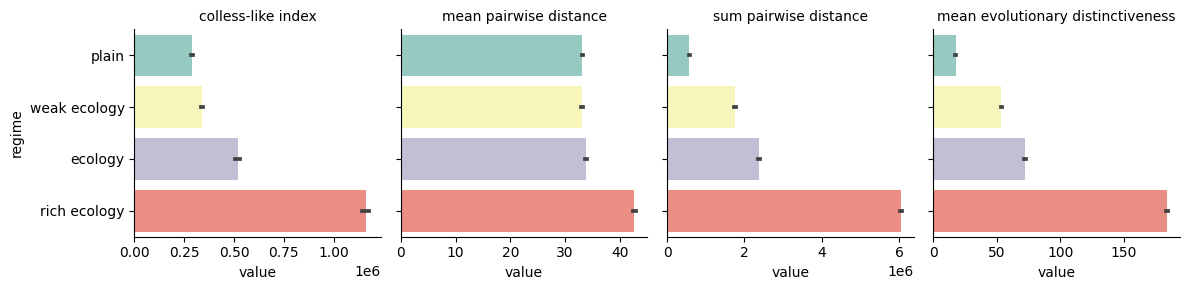

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


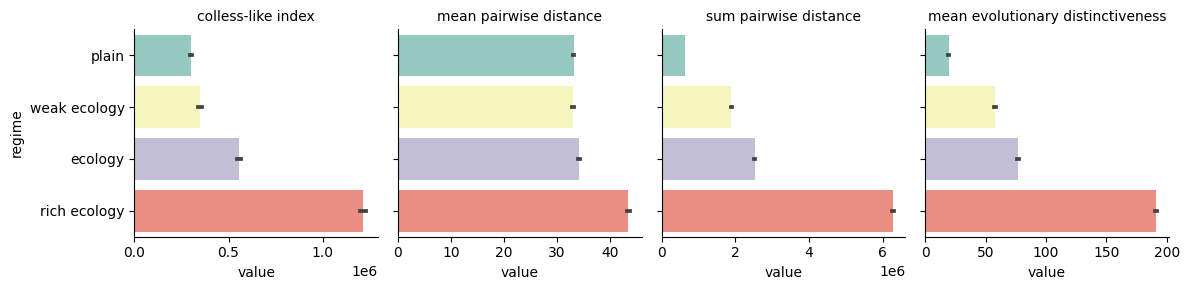

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


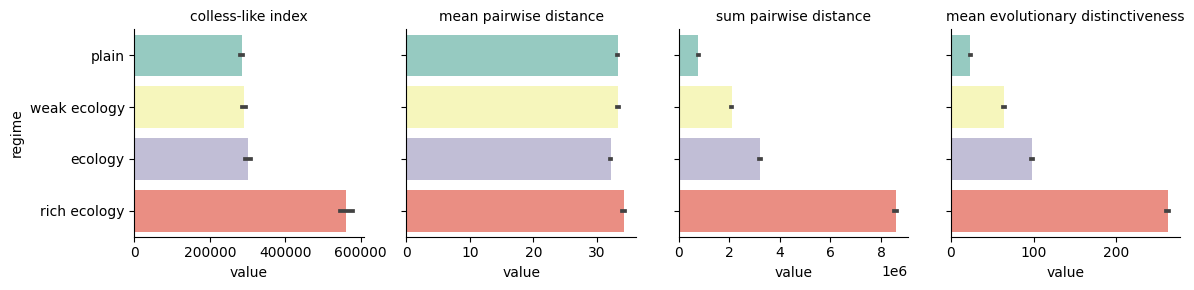

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


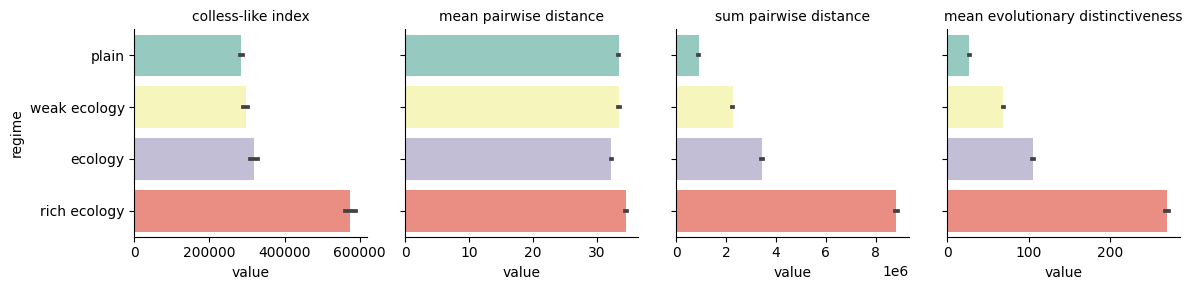

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


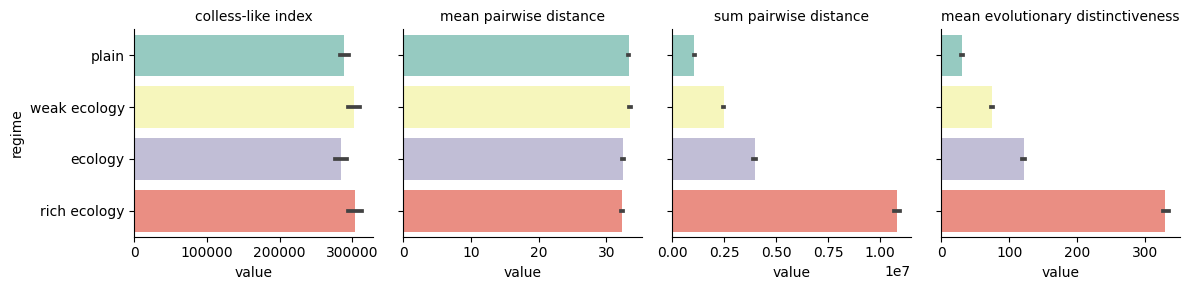

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png


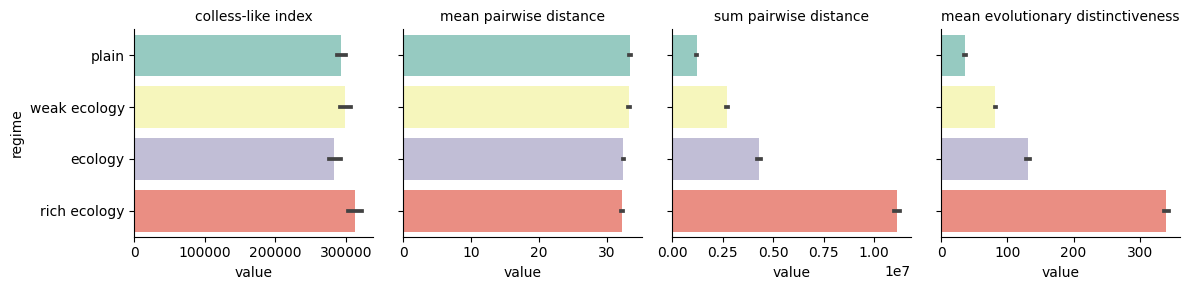

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


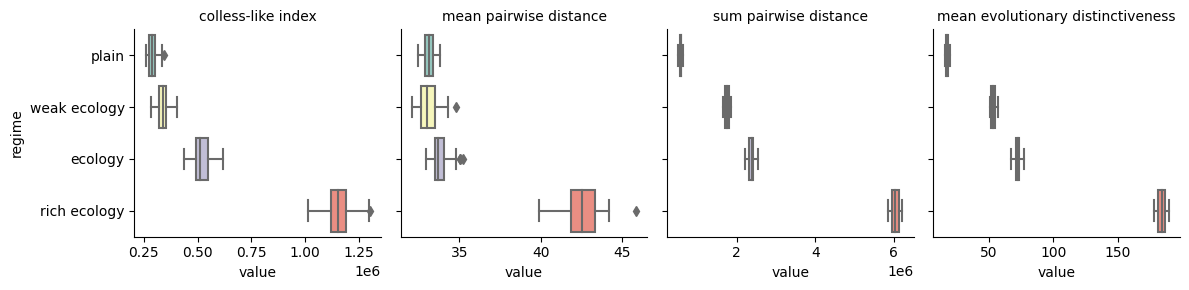

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


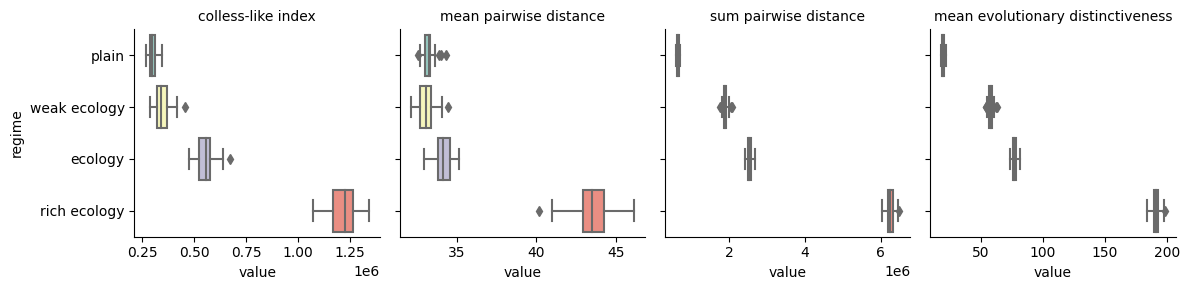

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


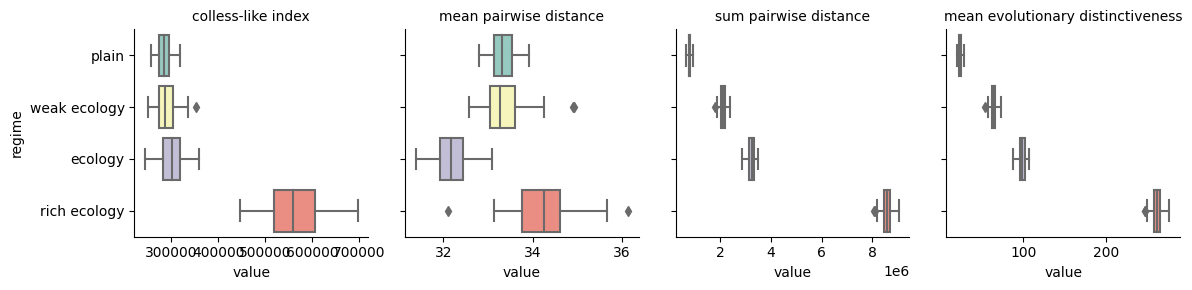

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


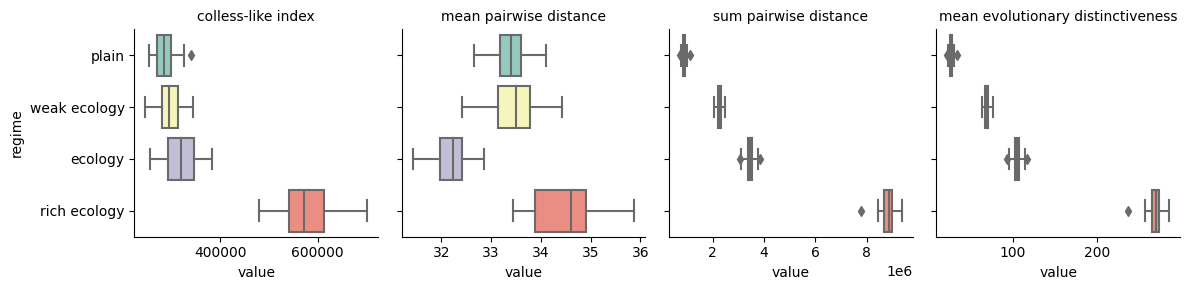

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


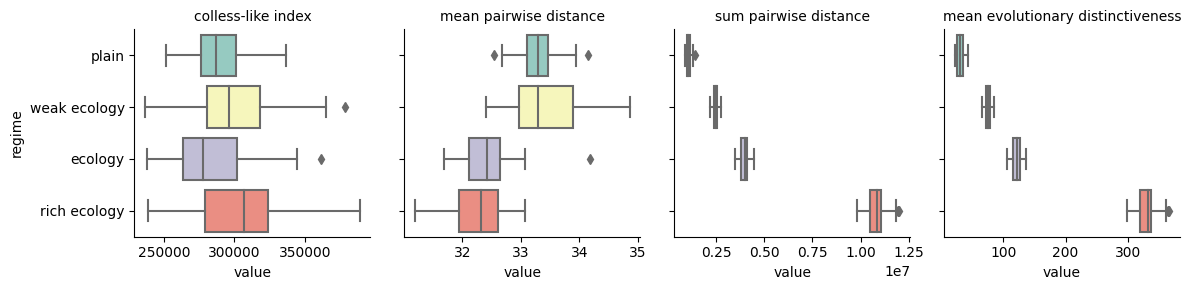

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=boxplot+x=value+y=regime+ext=.png


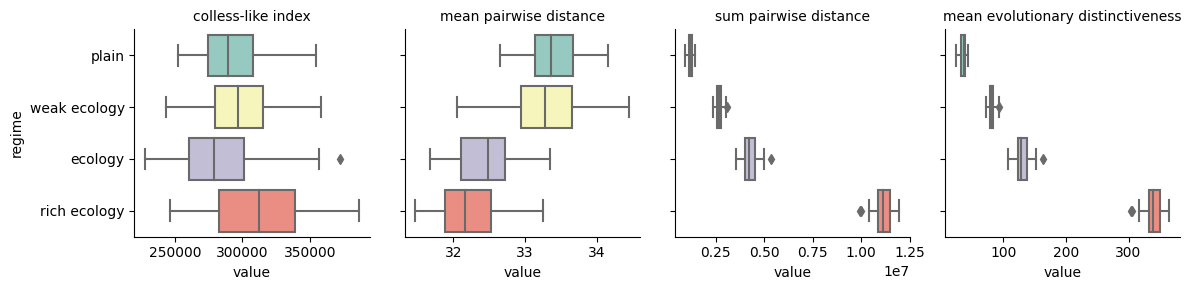

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


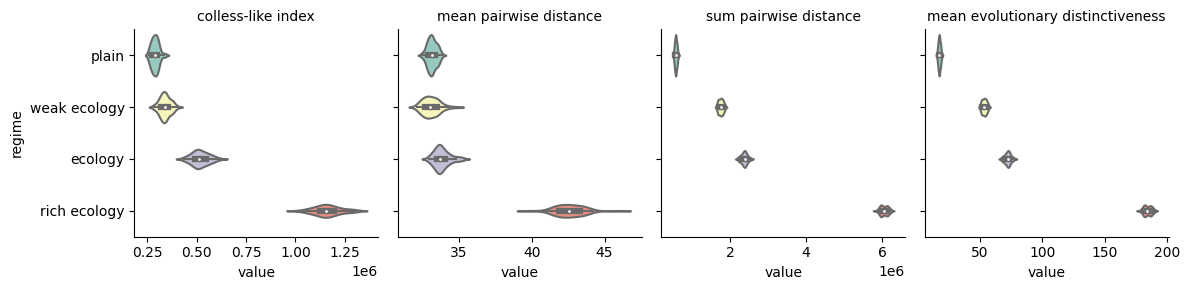

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


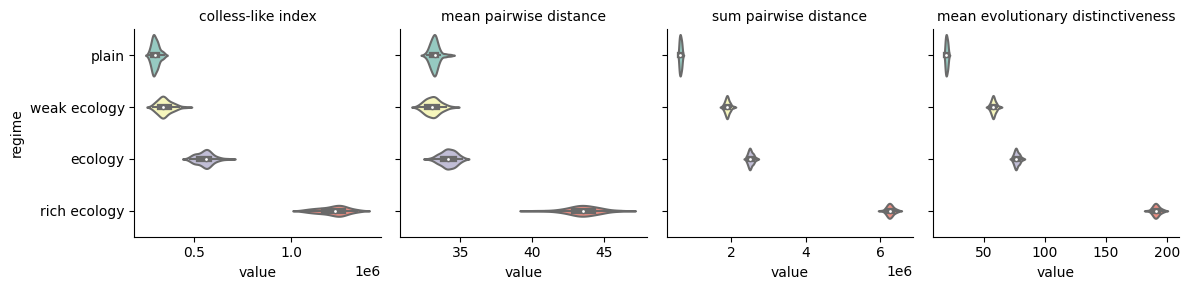

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


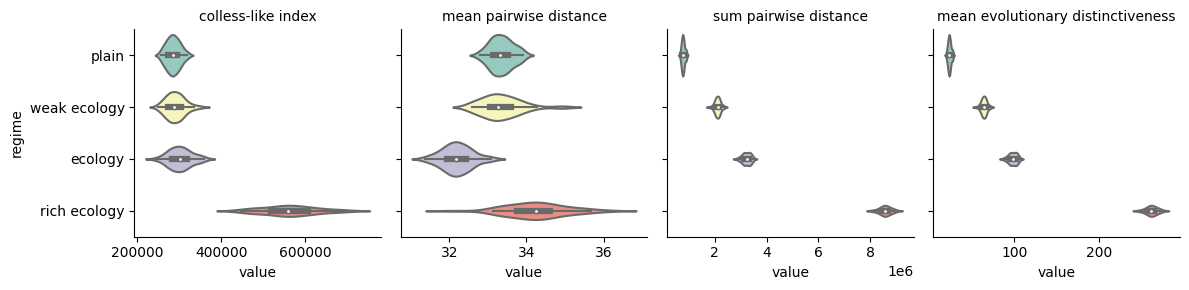

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


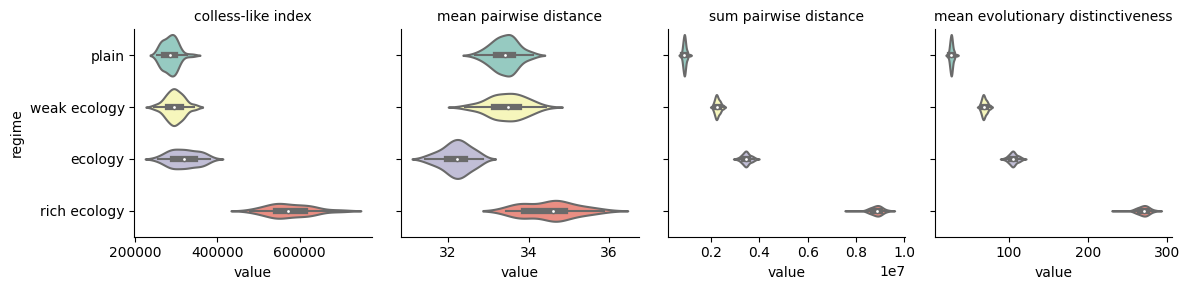

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


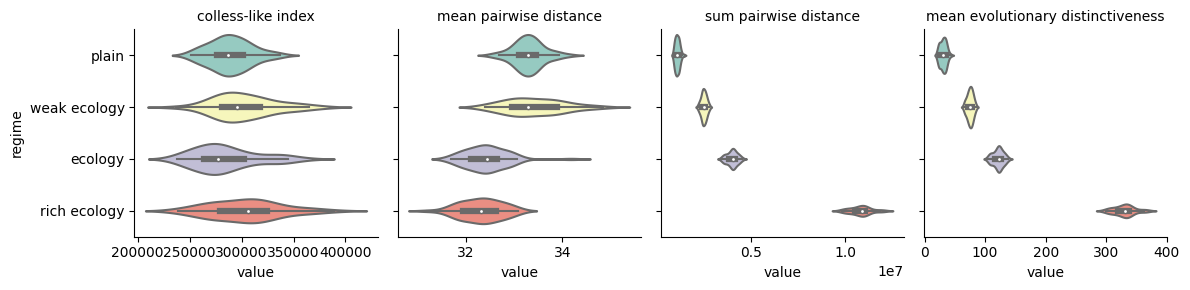

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=violinplot+x=value+y=regime+ext=.png


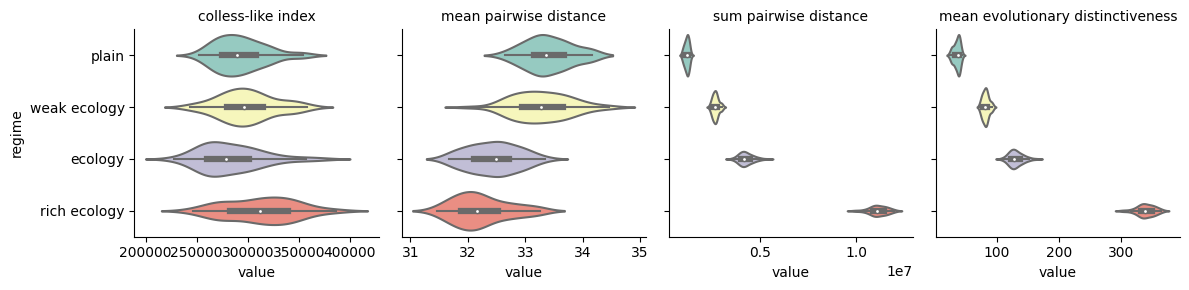

In [21]:
def make_do_plot(plotter):
    def do_plot(data, col, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            sharex=False,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "plain",
                "weak ecology",
                "ecology",
                "rich ecology",
            ],
            palette=sns.color_palette("Set3", 4),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        x="value",
        y="regime",
        teeplot_outattrs={
            **{
                "nuisance": "spatial-structure",
            },
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
        },
    )


teeplots/epoch=0+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


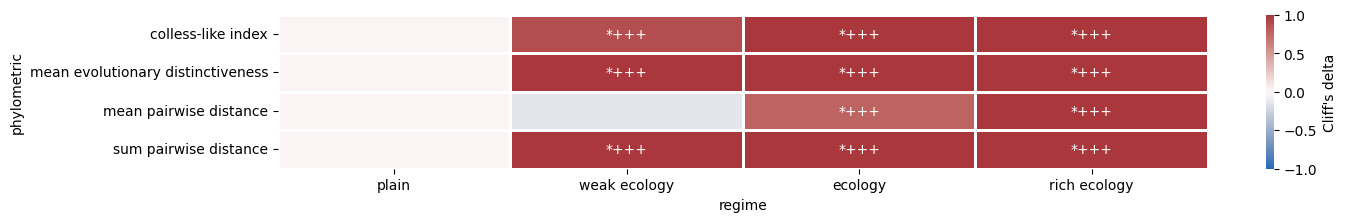

teeplots/epoch=0+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


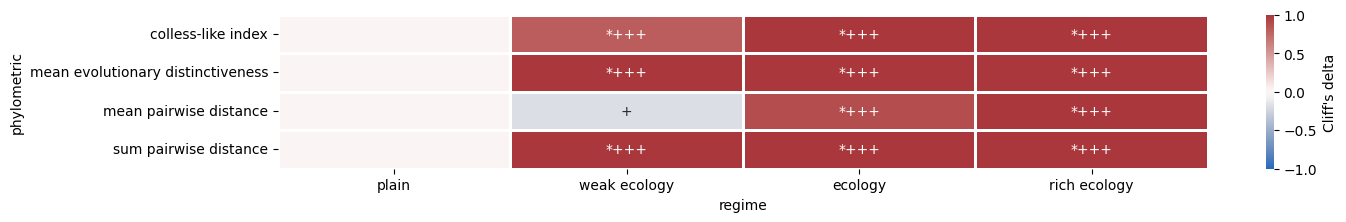

teeplots/epoch=2+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


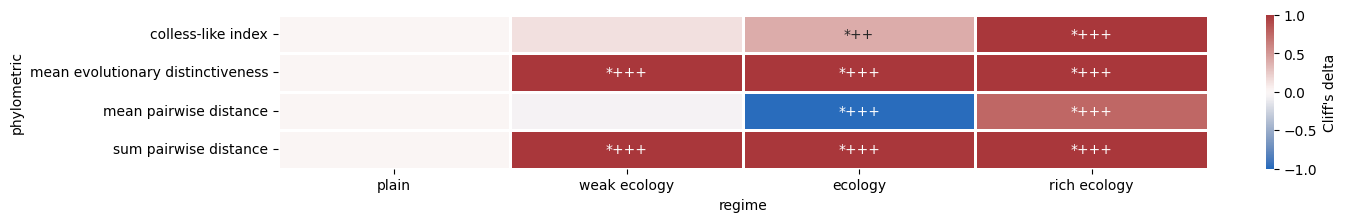

teeplots/epoch=2+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


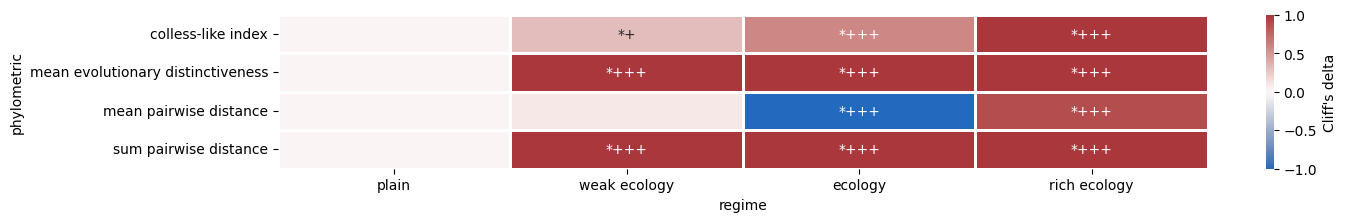

teeplots/epoch=7+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.exponential+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


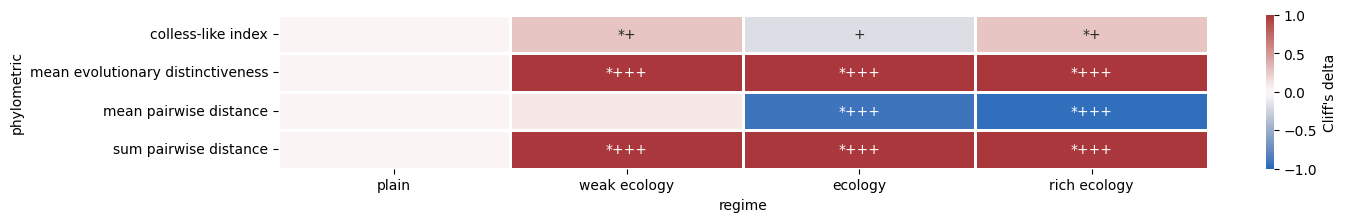

teeplots/epoch=7+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.standard_normal+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


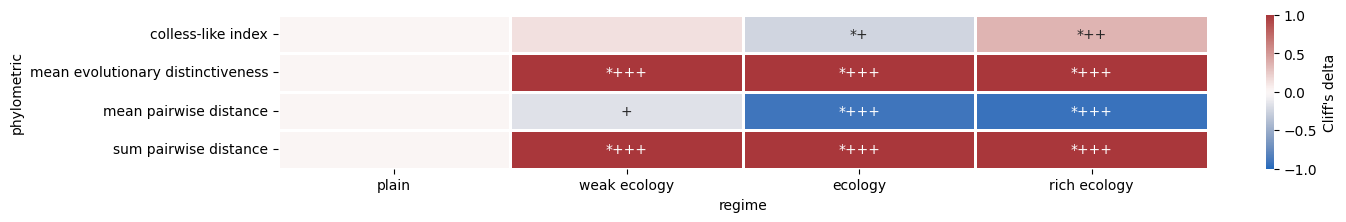

In [22]:
for (group, group_df) in df.groupby(sensitivity_analysis_variables):

    fil = (
        group_df[(group_df["a"] == "collapsed-phylogeny")]
        .copy()
        .dropna(subset=["regime"])
    )

    melted_df = fil.melt(
        id_vars=["regime"],
        value_vars=phylometrics,
    )
    melted_df["phylometric"] = melted_df["variable"]

    def calc_cliffs_delta(group) -> float:
        phylometric, regime = group.name
        return -cliffs_delta(
            fil[fil["regime"] == "plain"][phylometric],
            fil[fil["regime"] == regime][phylometric],
        )[0]

    melted_df = melted_df.groupby(["phylometric", "regime"]).apply(
        calc_cliffs_delta,
    ).reset_index(name="value")

    fig, ax = plt.subplots(figsize=(15, 2))

    matrix = melted_df.pivot(
        index="phylometric",
        columns="regime",
        values="value",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    annot = []
    for metric, row in matrix.iterrows():

        def getvec(regime: str) -> np.array:
            return fil[fil["regime"] == regime][metric].to_numpy()

        annot.append(
            [
                describe_effect(getvec("plain"), getvec(regime))
                for regime in matrix.columns
            ],
        )

    tp.tee(
        sns.heatmap,
        matrix,
        annot=annot,
        fmt="",
        linewidths=2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        center=0,
        cbar_kws={"label": "Cliff's delta"},
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "x": "regime",
                "y": "phylometric",
            },
            "spatial": "true",
        },
        teeplot_outexclude=["fmt"],
        vmin=-1,
        vmax=1,
    )


# stats: kruskal wallace among regimes


In [23]:
records = []
for phylometric in phylometrics:
    for group, group_df in df[(df["a"] == "collapsed-phylogeny")].groupby(
        sensitivity_analysis_variables,
        as_index=False,
    ):
        kw_result, n = scipy_stats.kruskal(
            *(
                quality_series
                for quality, quality_series in group_df.groupby(["regime"])[
                    phylometric
                ]
            )
        ), min(group_df.groupby(["regime"]).count()["a"])
        records.append(
            {
                **{
                    "n": n,
                    "N": len([*group_df.groupby(["regime"])]),
                    "phylometric": phylometric,
                },
                **dict(zip(["statistic", "p"], kw_result)),
                **dict(zip(sensitivity_analysis_variables, group)),
            }
        )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            sensitivity_analysis_variables,
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-spatial-nuisance-kwallis+ext=.csv",
        index=False,
    )


n  N                        phylometric   statistic             p  epoch  \
0   50  4                 colless-like index  182.463475  2.590889e-39      0   
1   50  4             mean pairwise distance  142.655857  1.011049e-30      0   
2   50  4              sum pairwise distance  186.567164  3.366062e-40      0   
3   50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      0   
4   50  4                 colless-like index  180.139033  8.230783e-39      0   
5   50  4             mean pairwise distance  155.228669  1.962095e-33      0   
6   50  4              sum pairwise distance  186.567164  3.366062e-40      0   
7   50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      0   
8   50  4                 colless-like index  118.649851  1.507305e-25      2   
9   50  4             mean pairwise distance  135.366496  3.770580e-29      2   
10  50  4              sum pairwise distance  186.567164  3.366062e-40      2   
11  50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      2   
12  50  4                 colless-like index  128.329946  1.238671e-27      2   
13  50  4             mean pairwise distance  151.095881  1.528830e-32      2   
14  50  4              sum pairwise distance  186.567164  3.366062e-40      2   
15  50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      2   
16  50  4                 colless-like index   15.898098  1.189858e-03      7   
17  50  4             mean pairwise distance  121.377469  3.897279e-26      7   
18  50  4              sum pairwise distance  186.567164  3.366062e-40      7   
19  50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      7   
20  50  4                 colless-like index   22.718615  4.622060e-05      7   
21  50  4             mean pairwise distance  118.175964  1.906556e-25      7   
22  50  4              sum pairwise distance  186.567164  3.366062e-40      7   
23  50  4  mean evolutionary distinctiveness  186.567164  3.366062e-40      7   

                    mut_distn  
0       np.random.exponential  
1       np.random.exponential  
2       np.random.exponential  
3       np.random.exponential  
4   np.random.standard_normal  
5   np.random.standard_normal  
6   np.random.standard_normal  
7   np.random.standard_normal  
8       np.random.exponential  
9       np.random.exponential  
10      np.random.exponential  
11      np.random.exponential  
12  np.random.standard_normal  
13  np.random.standard_normal  
14  np.random.standard_normal  
15  np.random.standard_normal  
16      np.random.exponential  
17      np.random.exponential  
18      np.random.exponential  
19      np.random.exponential  
20  np.random.standard_normal  
21  np.random.standard_normal  
22  np.random.standard_normal  
23  np.random.standard_normal

In [24]:
records = []
for phylometric in phylometrics:
    for group, group_df in df[(df["a"] == "collapsed-phylogeny")].groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        for regime1, regime2 in it.combinations(
            group_df["regime"].unique(), 2
        ):
            kw_result, n = scipy_stats.wilcoxon(
                *zip(
                    *zip(
                        group_df[group_df["regime"] == regime1][phylometric],
                        group_df[group_df["regime"] == regime2][phylometric],
                    )
                ),
            ), min(group_df.groupby(["regime"]).count()["a"])
            records.append(
                {
                    **{
                        "regime1": regime1,
                        "regime2": regime2,
                        "n": n,
                        "phylometric": phylometric,
                    },
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(zip(sensitivity_analysis_variables, group)),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime1", "regime2"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-allpairs-spatial-nuisance-wilcox+ext=.csv",
        index=False,
    )


regime1       regime2   n                        phylometric  \
0         ecology         plain  50                 colless-like index   
1         ecology         plain  50             mean pairwise distance   
2         ecology         plain  50              sum pairwise distance   
3         ecology         plain  50  mean evolutionary distinctiveness   
4         ecology  rich ecology  50                 colless-like index   
5         ecology  rich ecology  50             mean pairwise distance   
6         ecology  rich ecology  50              sum pairwise distance   
7         ecology  rich ecology  50  mean evolutionary distinctiveness   
8         ecology  weak ecology  50                 colless-like index   
9         ecology  weak ecology  50             mean pairwise distance   
10        ecology  weak ecology  50              sum pairwise distance   
11        ecology  weak ecology  50  mean evolutionary distinctiveness   
12          plain  rich ecology  50                 colless-like index   
13          plain  rich ecology  50             mean pairwise distance   
14          plain  rich ecology  50              sum pairwise distance   
15          plain  rich ecology  50  mean evolutionary distinctiveness   
16   weak ecology         plain  50                 colless-like index   
17   weak ecology         plain  50             mean pairwise distance   
18   weak ecology         plain  50              sum pairwise distance   
19   weak ecology         plain  50  mean evolutionary distinctiveness   
20   weak ecology  rich ecology  50                 colless-like index   
21   weak ecology  rich ecology  50             mean pairwise distance   
22   weak ecology  rich ecology  50              sum pairwise distance   
23   weak ecology  rich ecology  50  mean evolutionary distinctiveness   
24          plain       ecology  50                 colless-like index   
25          plain       ecology  50             mean pairwise distance   
26          plain       ecology  50              sum pairwise distance   
27          plain       ecology  50  mean evolutionary distinctiveness   
28          plain  rich ecology  50                 colless-like index   
29          plain  rich ecology  50             mean pairwise distance   
30          plain  rich ecology  50              sum pairwise distance   
31          plain  rich ecology  50  mean evolutionary distinctiveness   
32          plain  weak ecology  50                 colless-like index   
33          plain  weak ecology  50             mean pairwise distance   
34          plain  weak ecology  50              sum pairwise distance   
35          plain  weak ecology  50  mean evolutionary distinctiveness   
36   rich ecology       ecology  50                 colless-like index   
37   rich ecology       ecology  50             mean pairwise distance   
38   rich ecology       ecology  50              sum pairwise distance   
39   rich ecology       ecology  50  mean evolutionary distinctiveness   
40   rich ecology  weak ecology  50                 colless-like index   
41   rich ecology  weak ecology  50             mean pairwise distance   
42   rich ecology  weak ecology  50              sum pairwise distance   
43   rich ecology  weak ecology  50  mean evolutionary distinctiveness   
44   weak ecology       ecology  50                 colless-like index   
45   weak ecology       ecology  50             mean pairwise distance   
46   weak ecology       ecology  50              sum pairwise distance   
47   weak ecology       ecology  50  mean evolutionary distinctiveness   
48        ecology  weak ecology  50                 colless-like index   
49        ecology  weak ecology  50             mean pairwise distance   
50        ecology  weak ecology  50              sum pairwise distance   
51        ecology  weak ecology  50  mean evolutionary distinctiveness   
52          plain       ecology  50                 colless-like index   
53          pl

# reconstructed phylogenetic data


In [25]:
df["quality"] = df.apply(
    lambda row: {
        ("reconstructed-tree", 3.0): "33% resolution",
        ("reconstructed-tree", 10.0): "10% resolution",
        ("reconstructed-tree", 30.0): "3% resolution",
        ("reconstructed-tree", 100.0): "1% resolution",
        ("collapsed-phylogeny", 0): "perfect resolution",
    }.get(
        tuple(row[["a", "resolution"]].fillna(0)),
        np.nan,  # default
    ),
    axis="columns",
)
df["quality"].unique()


array(['10% resolution', '1% resolution', '3% resolution',
       '33% resolution', 'perfect resolution'], dtype=object)

In [26]:
melted_df = df.melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime", "a", "quality"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


num_niches  resolution  epoch              mut_distn        regime  \
0               4        10.0      7  np.random.exponential       ecology   
1               4       100.0      7  np.random.exponential       ecology   
2               4        30.0      7  np.random.exponential       ecology   
3               4       100.0      7  np.random.exponential       ecology   
4               4       100.0      7  np.random.exponential       ecology   
...           ...         ...    ...                    ...           ...   
23995           4         NaN      2  np.random.exponential  weak ecology   
23996           4         NaN      2  np.random.exponential  weak ecology   
23997           4         NaN      2  np.random.exponential  weak ecology   
23998           4         NaN      2  np.random.exponential  weak ecology   
23999           4         NaN      2  np.random.exponential  weak ecology   

                         a             quality  \
0       reconstructed-tree      10% resolution   
1       reconstructed-tree       1% resolution   
2       reconstructed-tree       3% resolution   
3       reconstructed-tree       1% resolution   
4       reconstructed-tree       1% resolution   
...                    ...                 ...   
23995  collapsed-phylogeny  perfect resolution   
23996  collapsed-phylogeny  perfect resolution   
23997  collapsed-phylogeny  perfect resolution   
23998  collapsed-phylogeny  perfect resolution   
23999  collapsed-phylogeny  perfect resolution   

                                variable          value  \
0                     colless-like index  272137.093188   
1                     colless-like index  279421.467846   
2                     colless-like index  243142.475459   
3                     colless-like index  254305.046082   
4                     colless-like index  254990.108988   
...                                  ...            ...   
23995  mean evolutionary distinctiveness      62.567078   
23996  mean evolutionary distinctiveness      54.291748   
23997  mean evolutionary distinctiveness      61.928589   
23998  mean evolutionary distinctiveness      65.404114   
23999  mean evolutionary distinctiveness      61.885101   

                             phylometric  
0                     colless-like index  
1                     colless-like index  
2                     colless-like index  
3                     colless-like index  
4                     colless-like index  
...                                  ...  
23995  mean evolutionary distinctiveness  
23996  mean evolutionary distinctiveness  
23997  mean evolutionary distinctiveness  
23998  mean evolutionary distinctiveness  
23999  mean evolutionary distinctiveness  

[24000 rows x 10 columns]

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


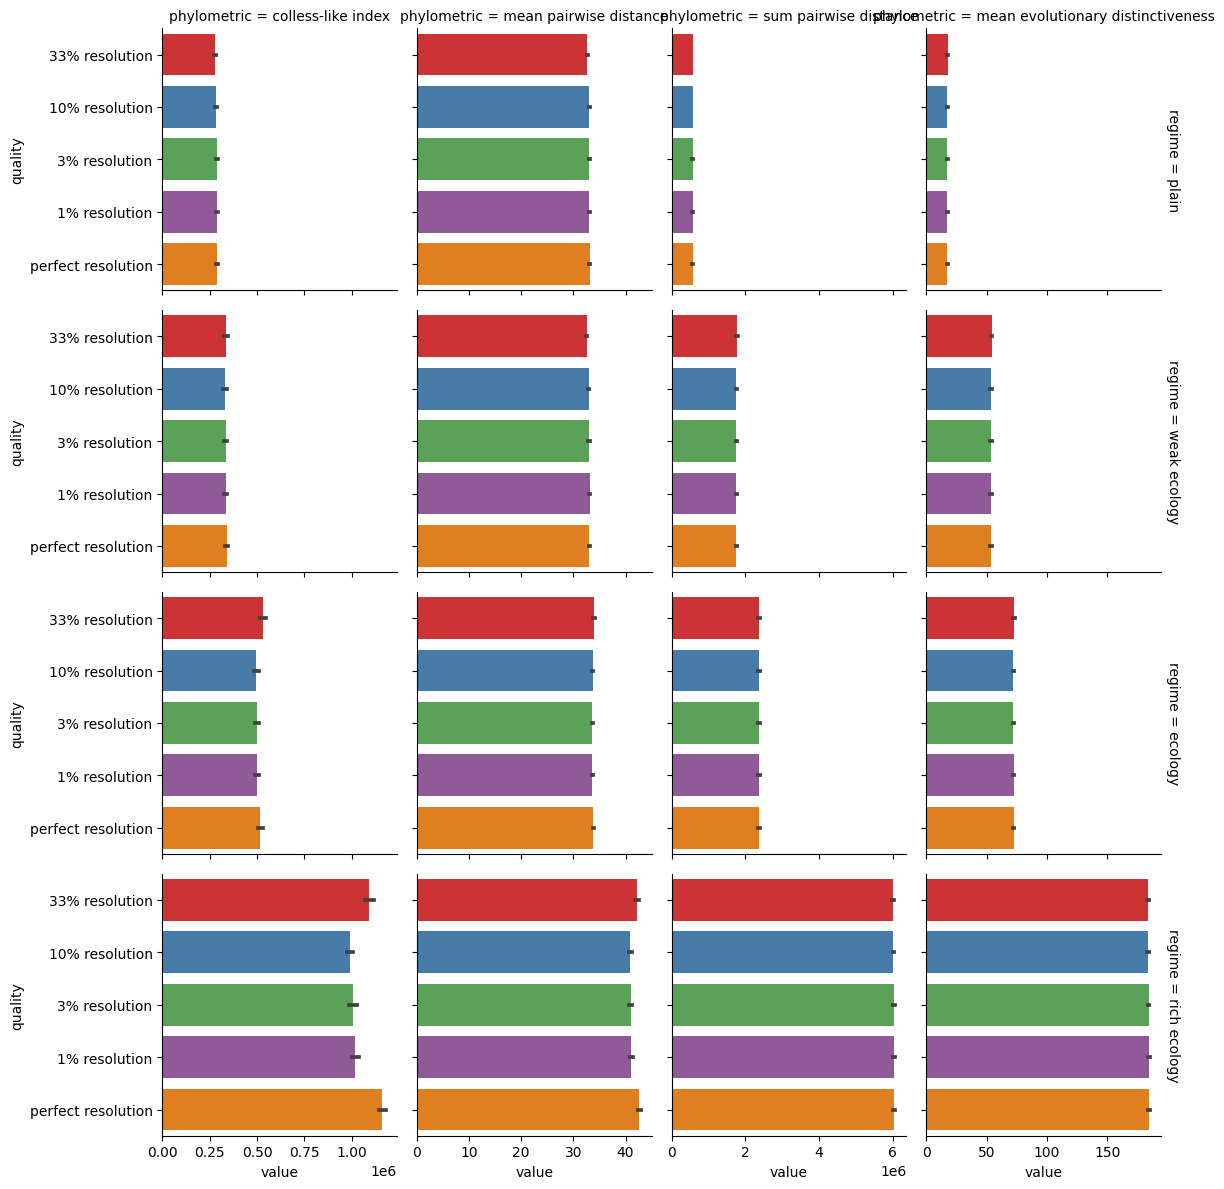

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


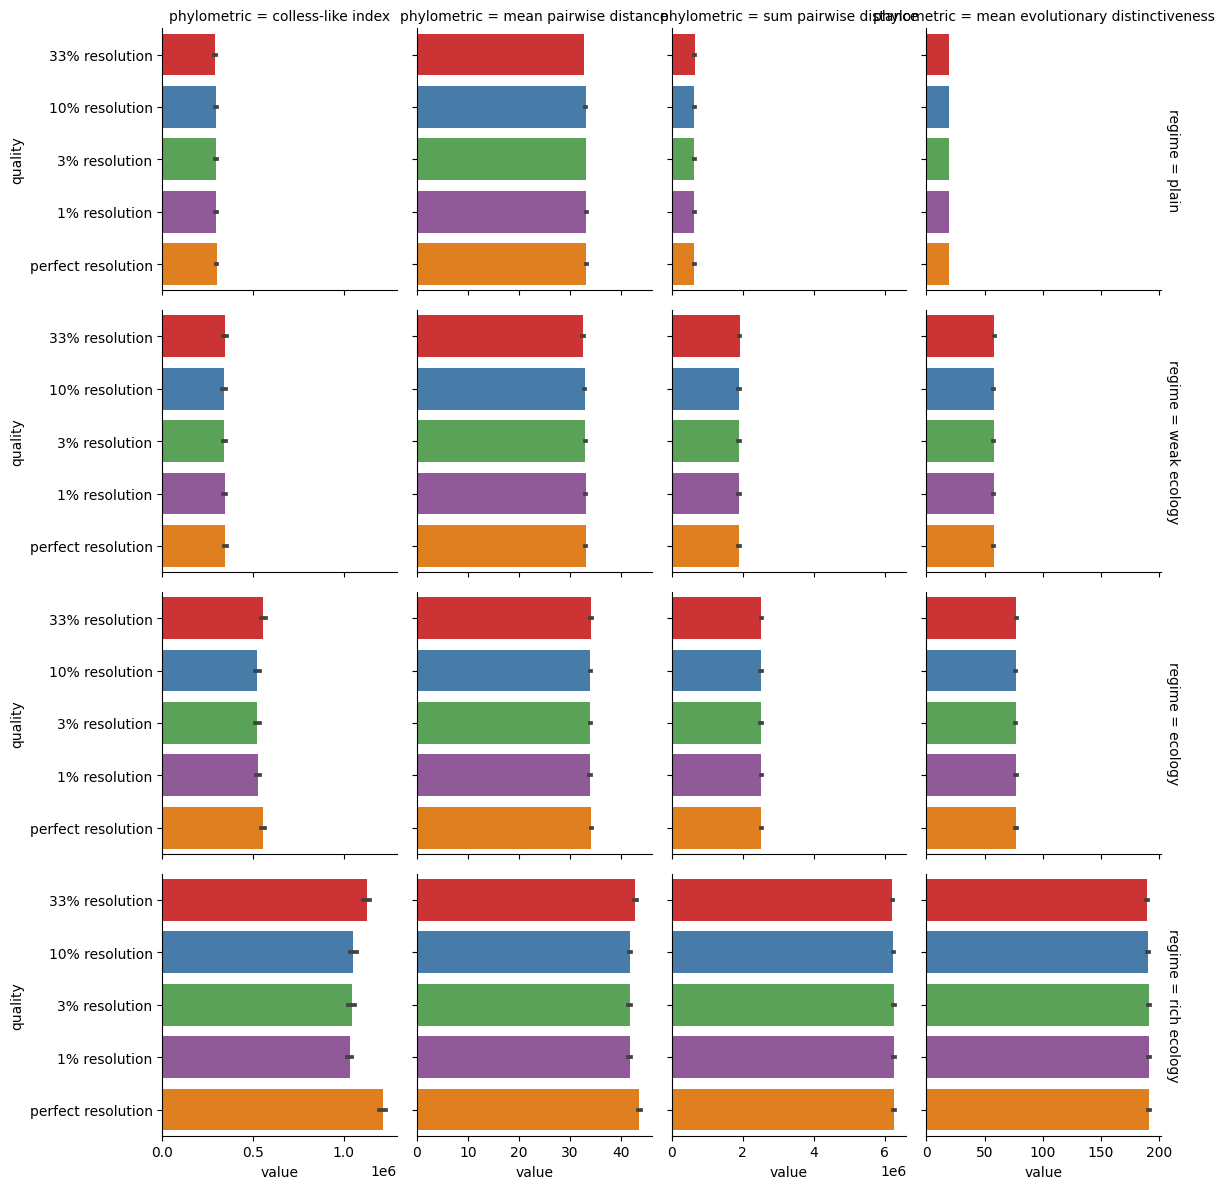

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


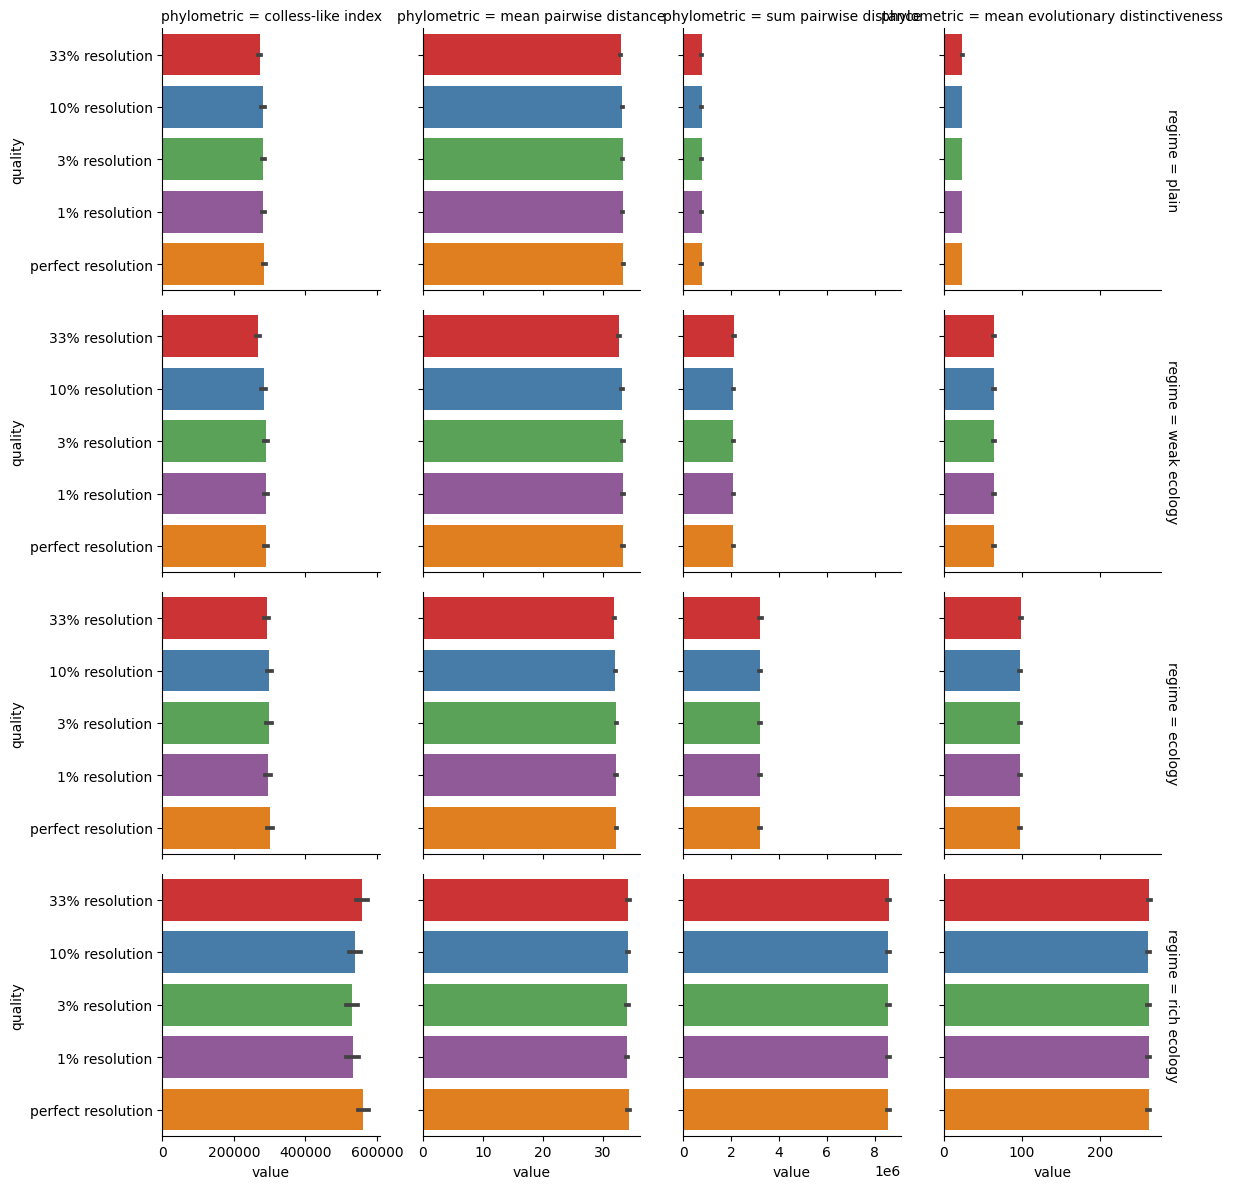

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


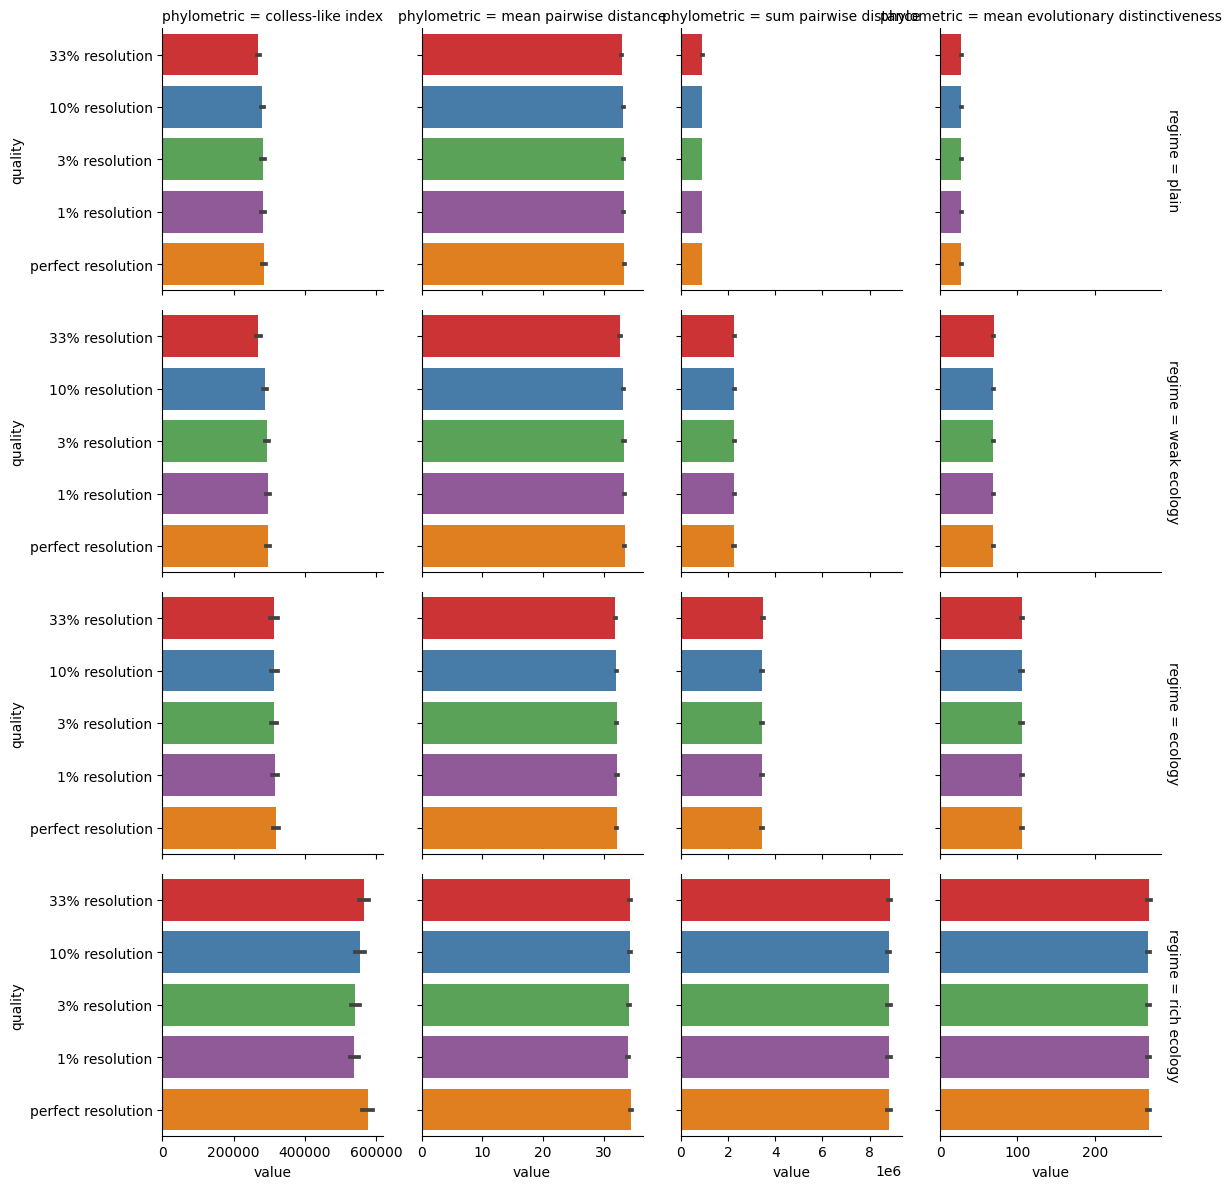

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


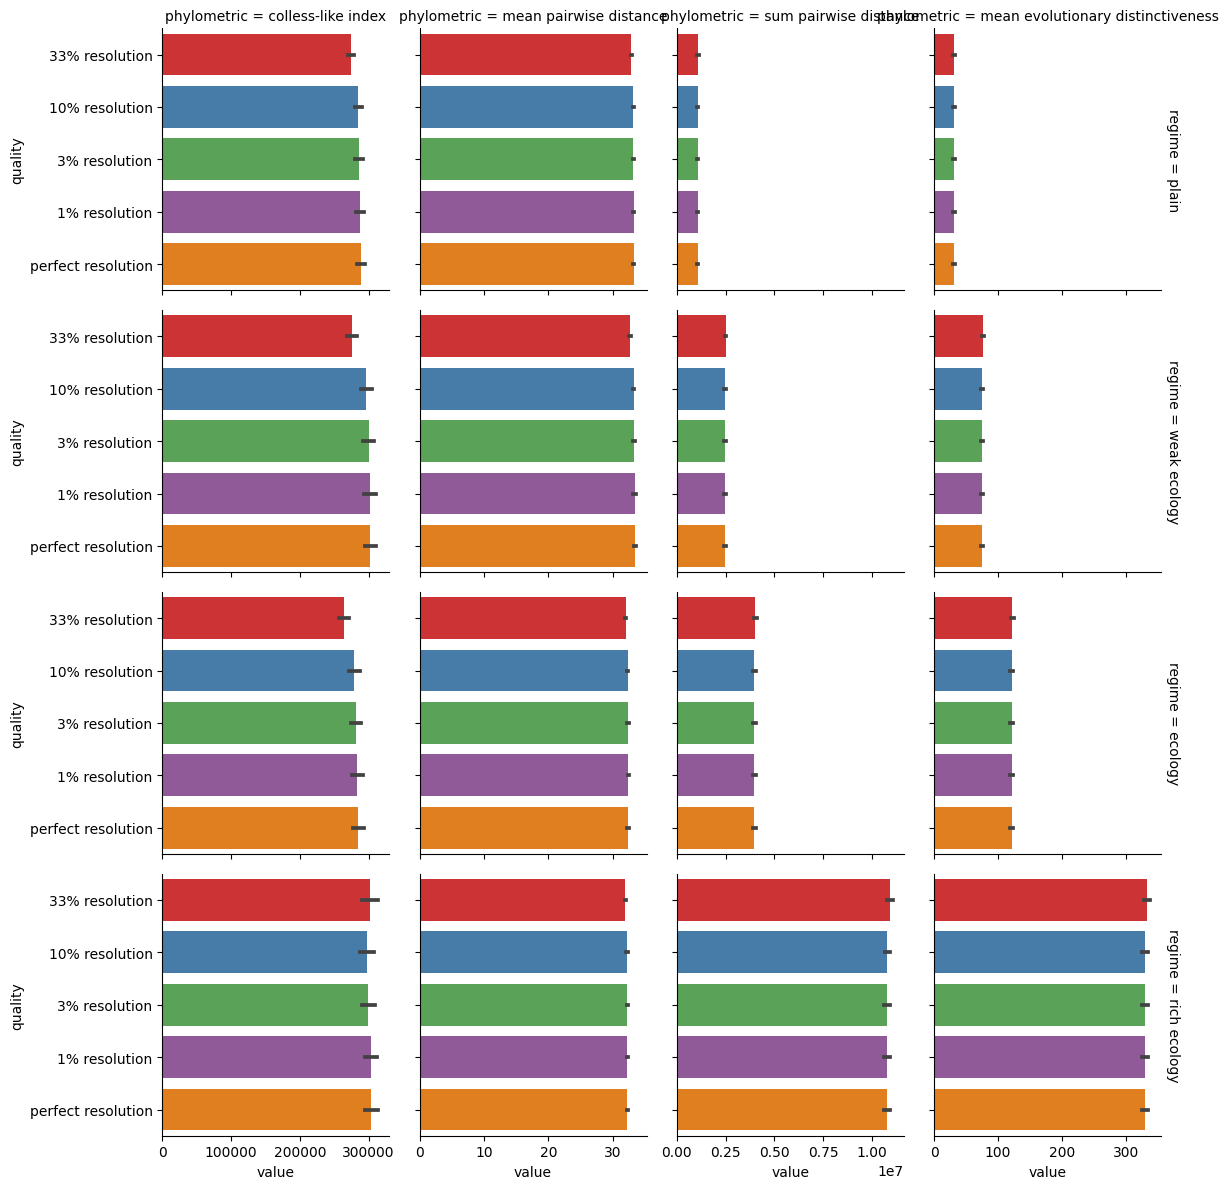

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png


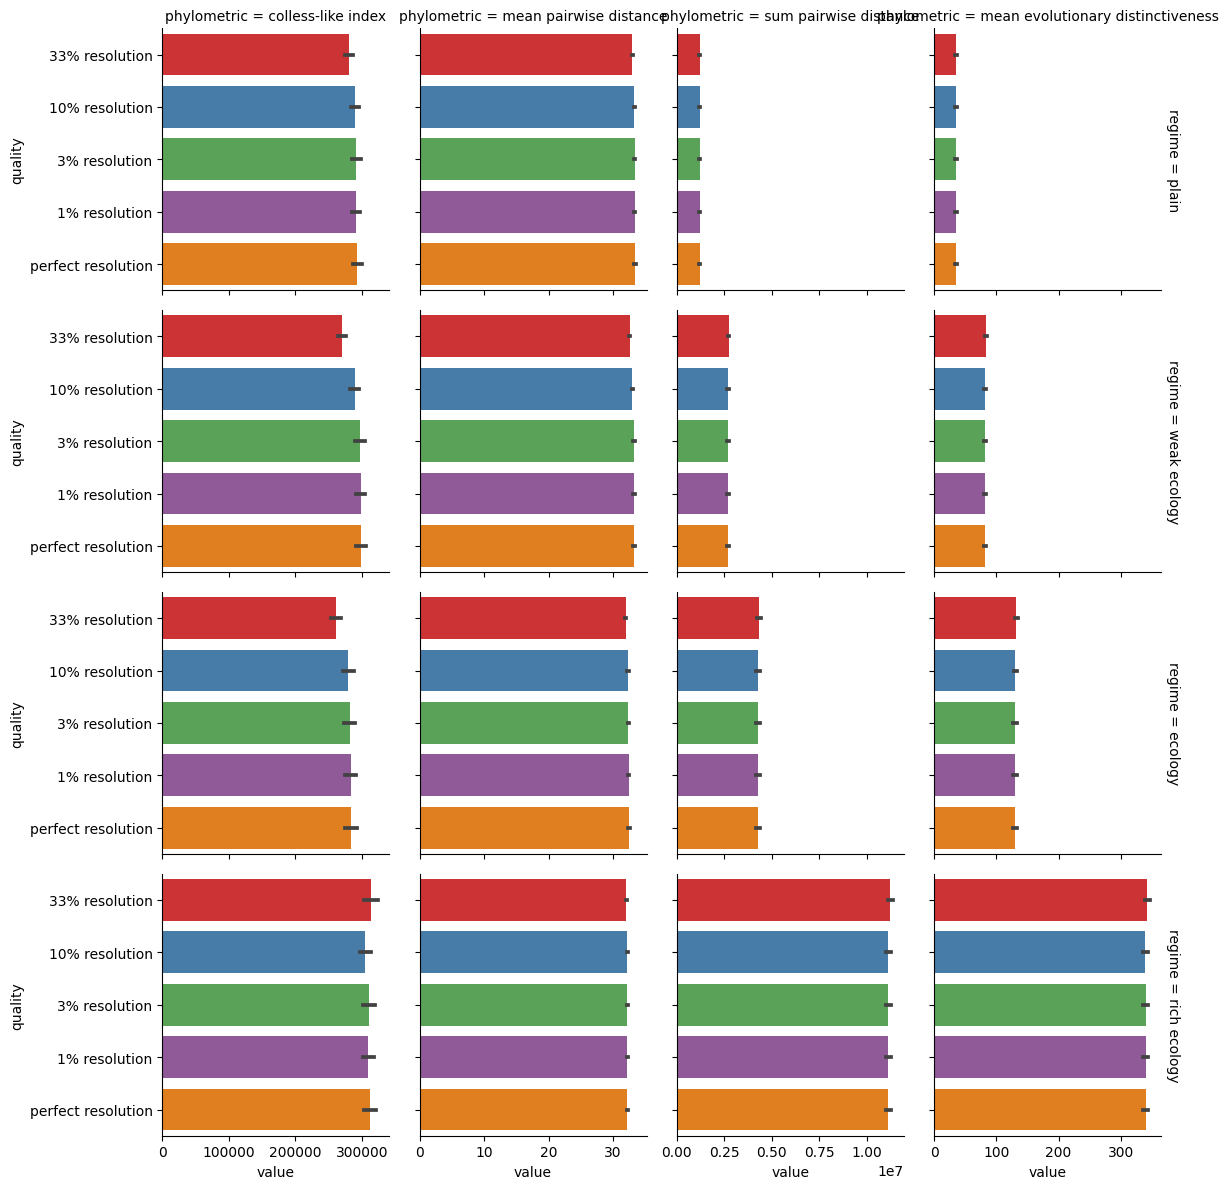

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


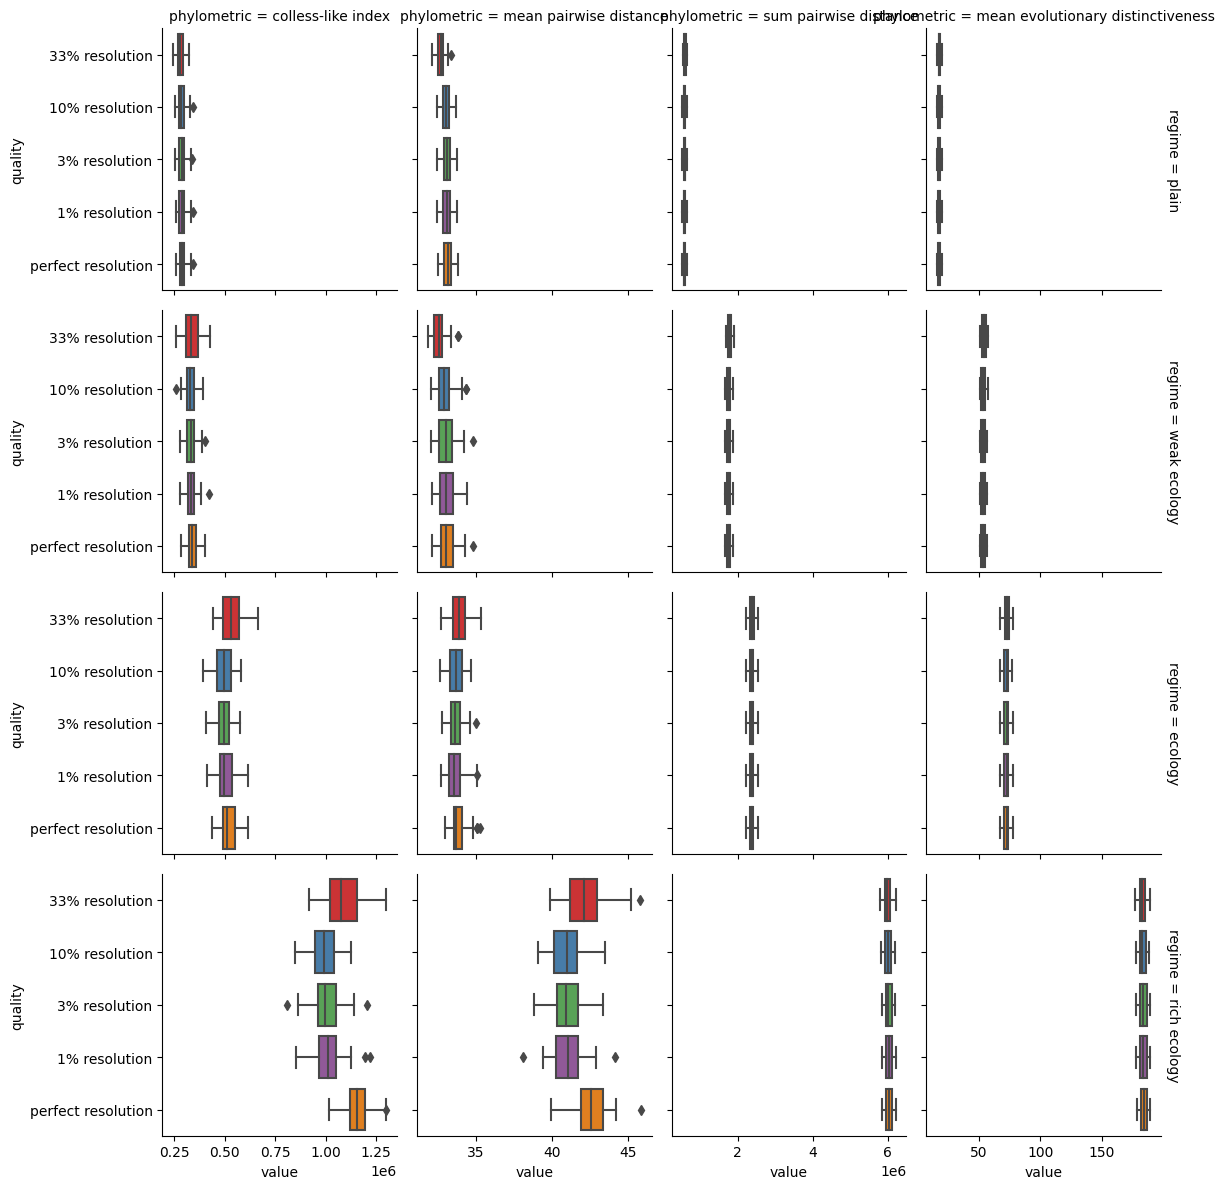

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


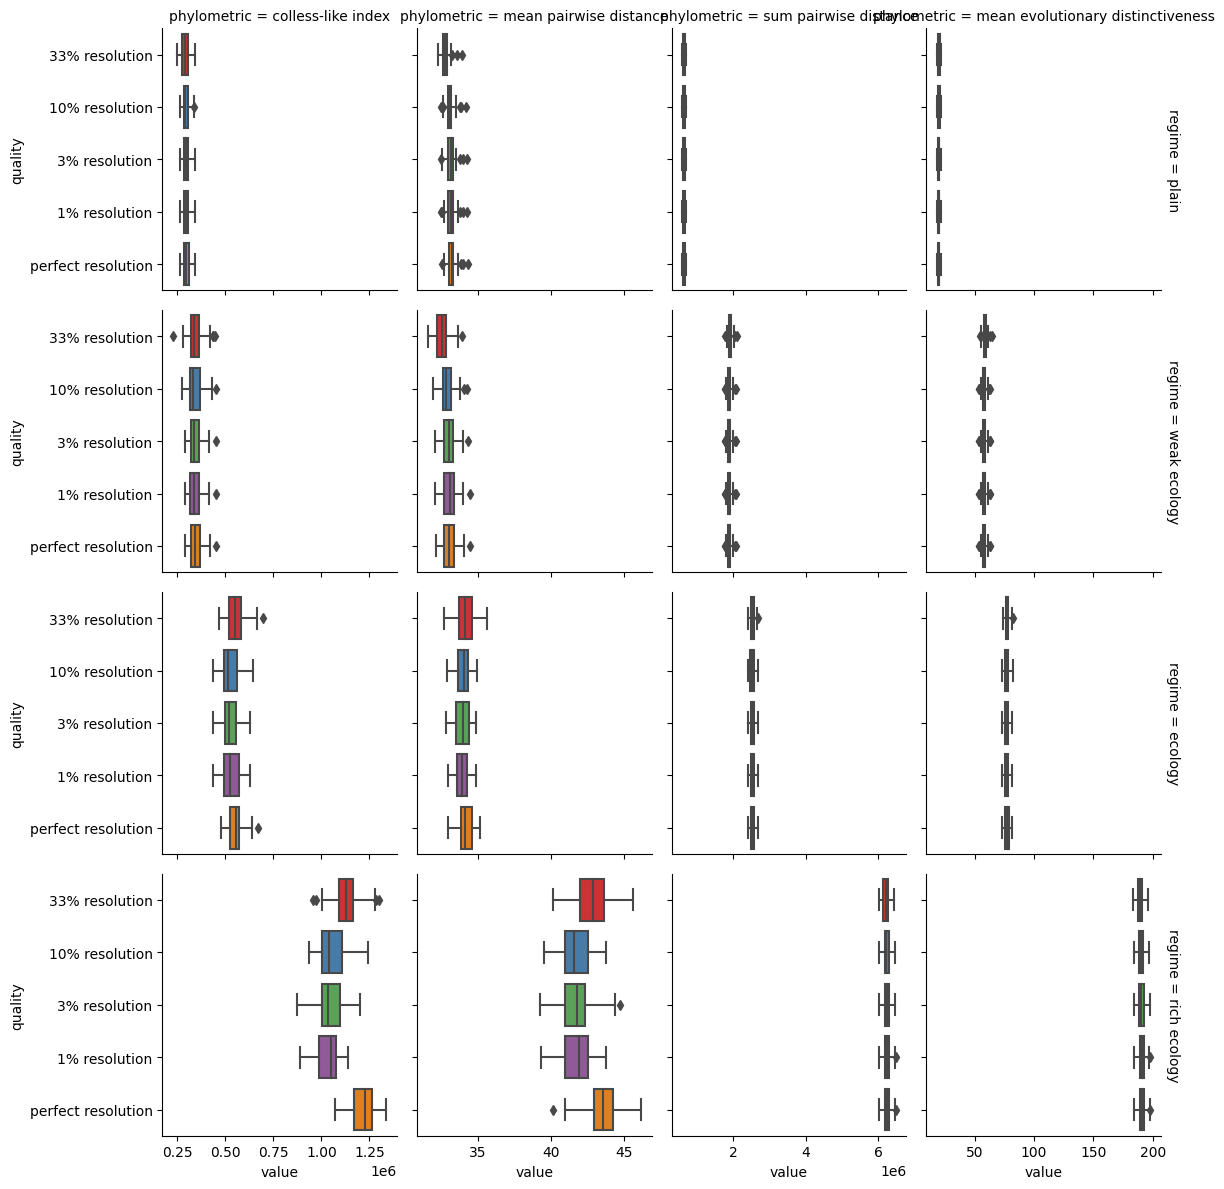

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


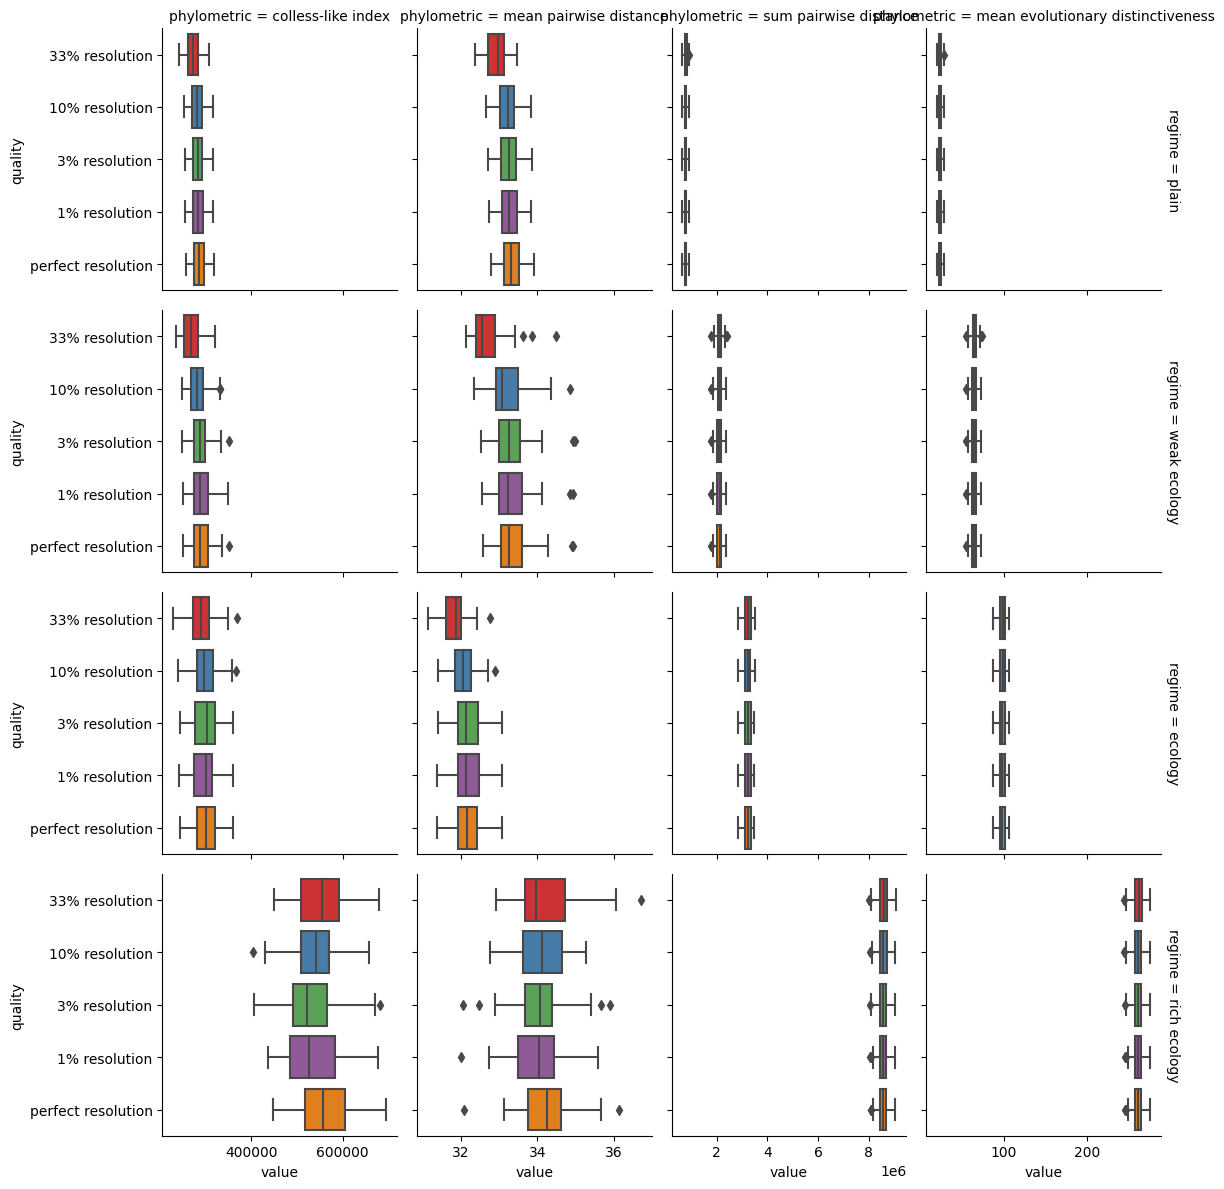

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


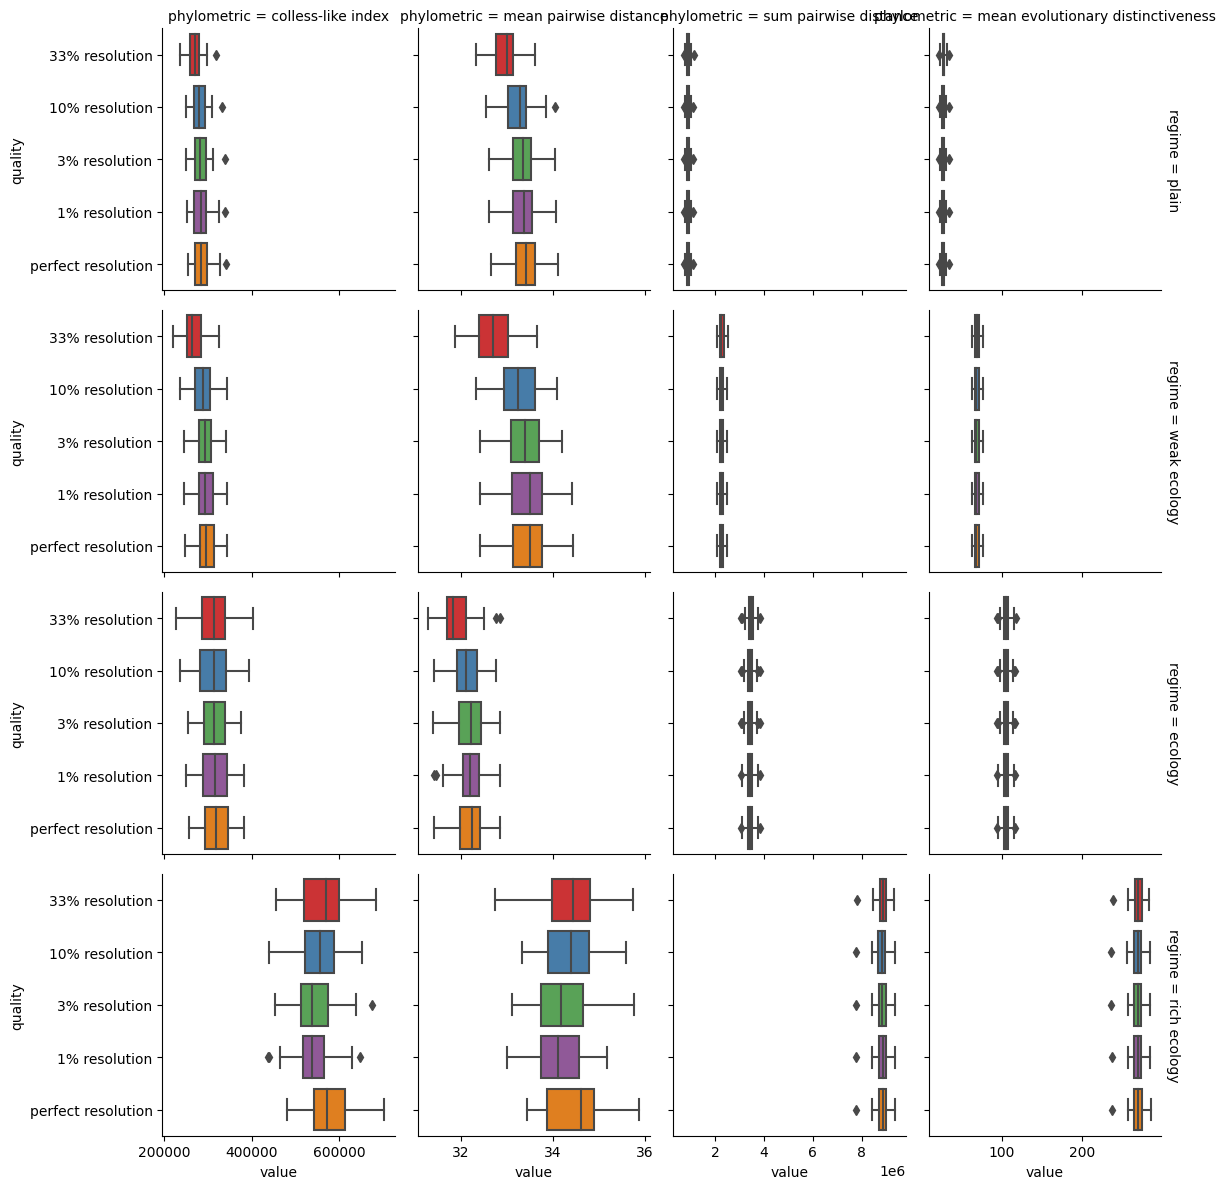

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


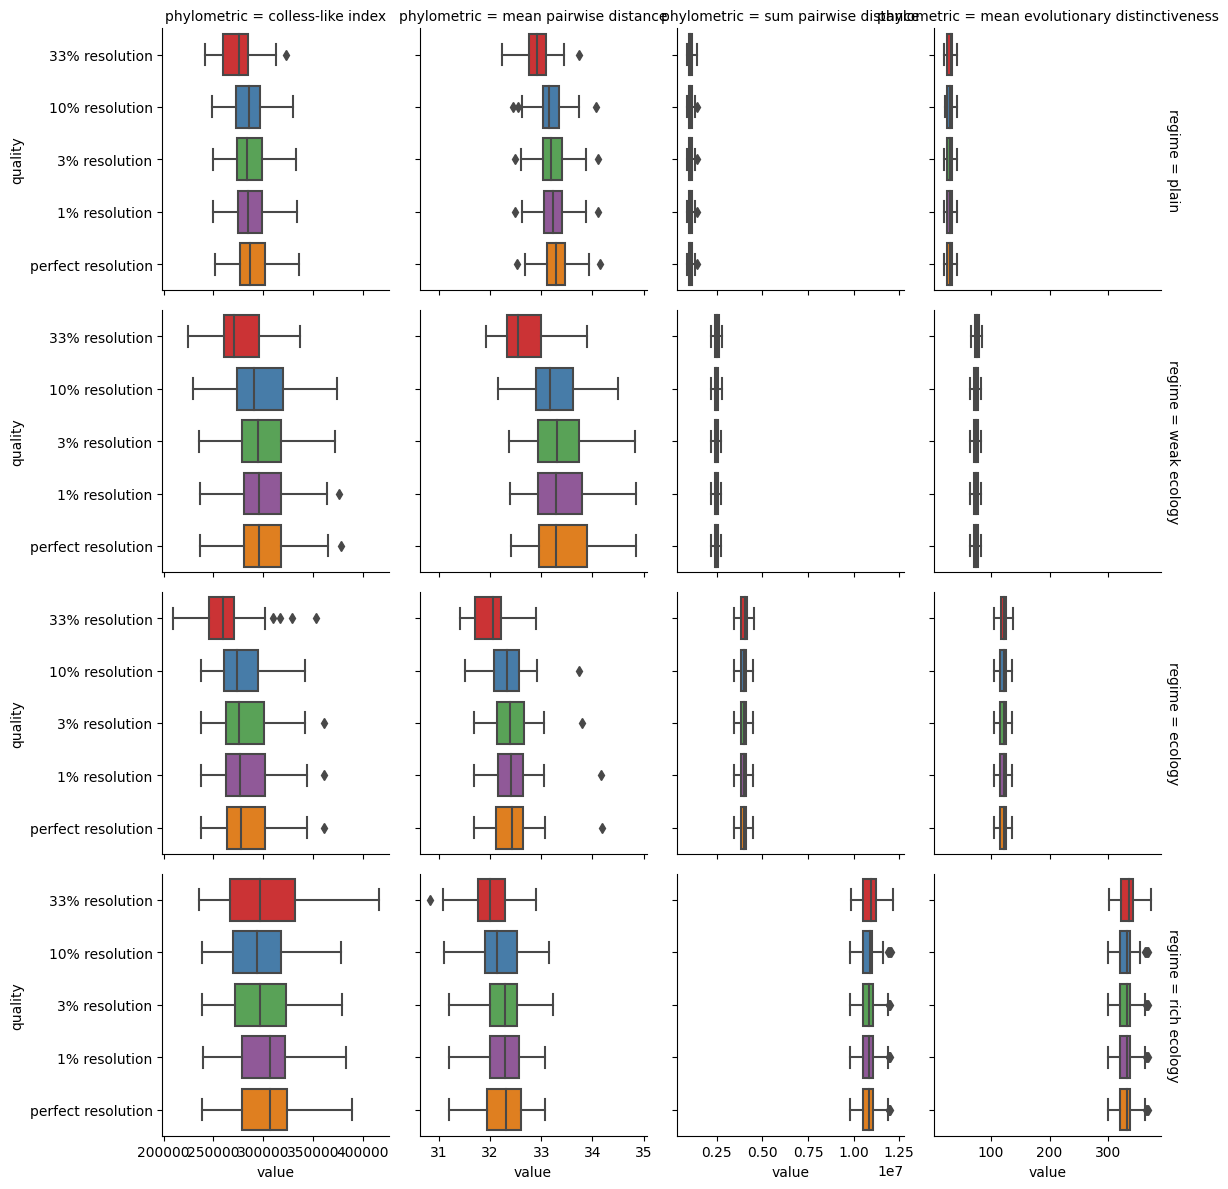

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=boxplot+x=value+y=quality+ext=.png


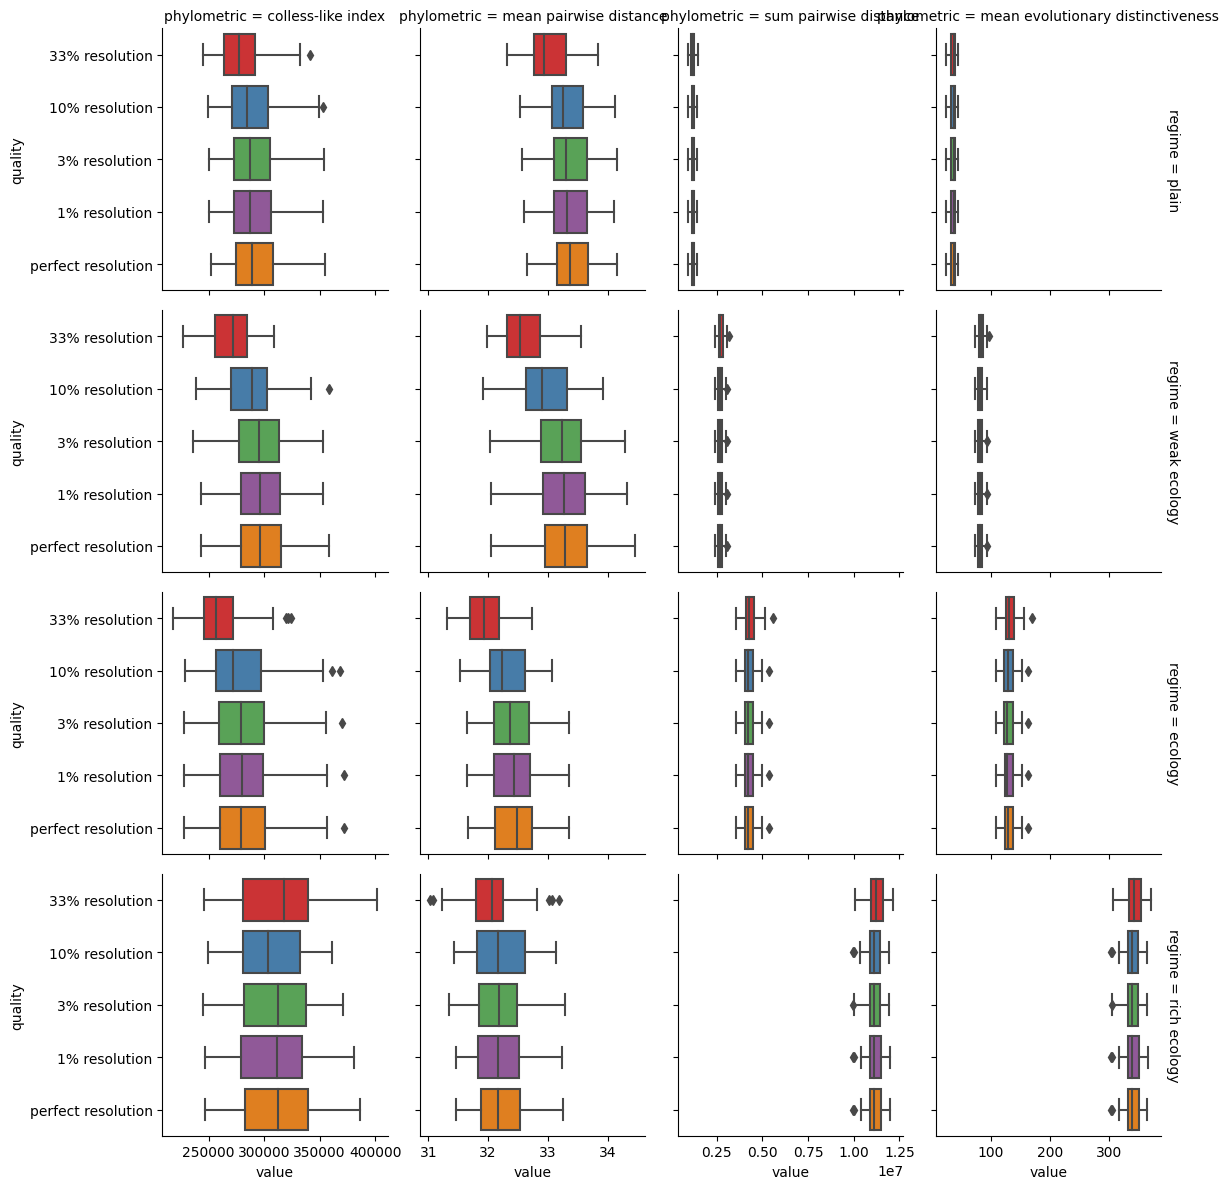

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


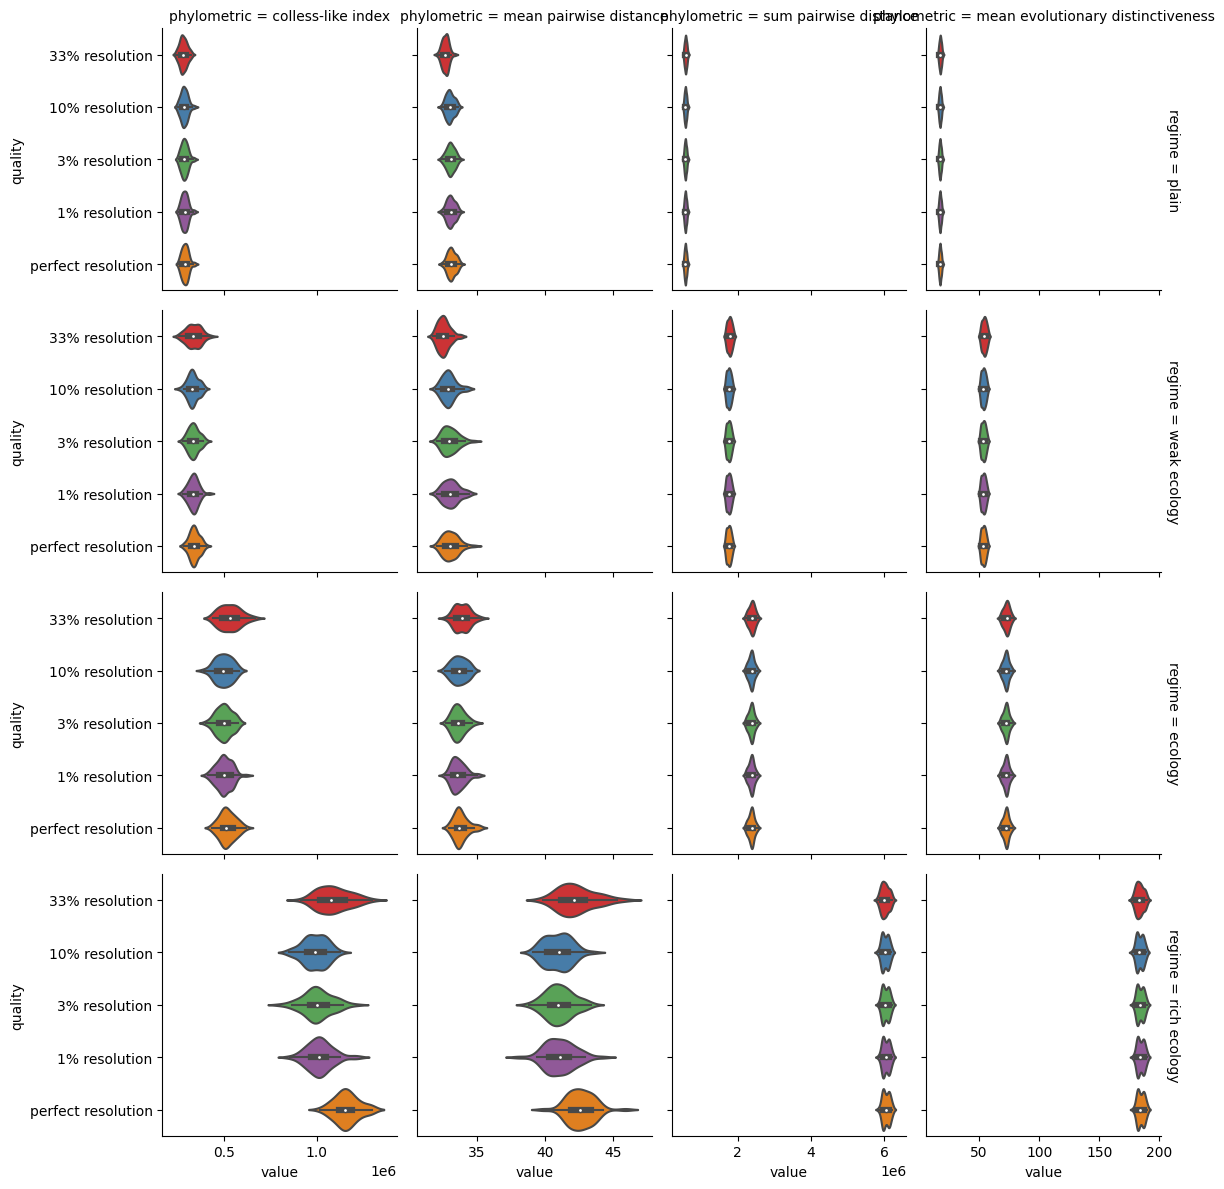

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


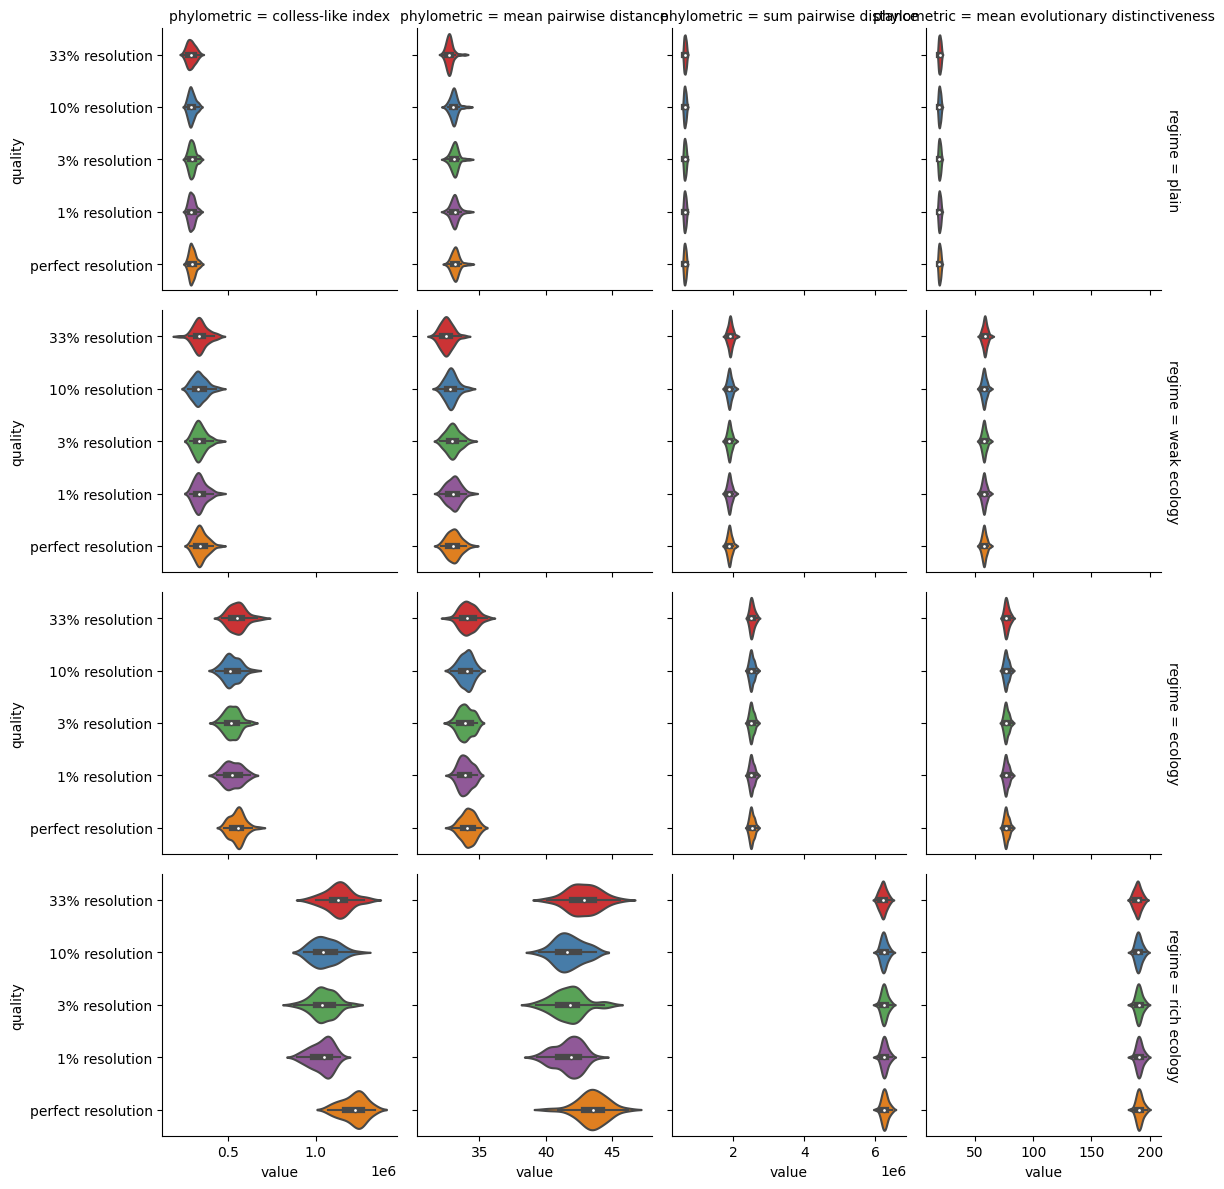

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


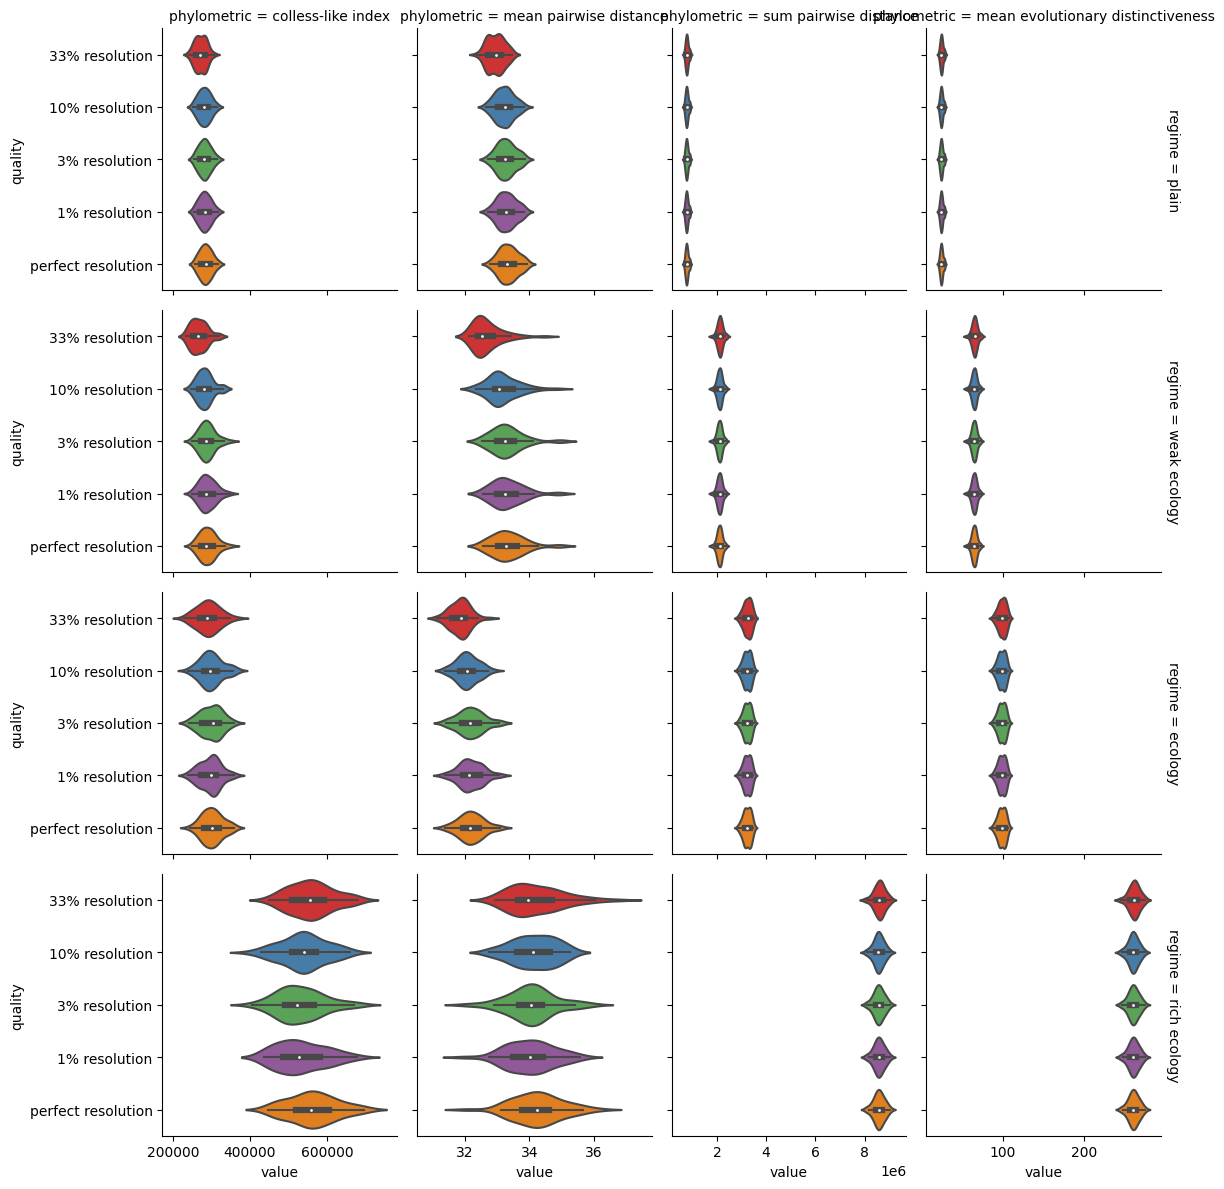

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


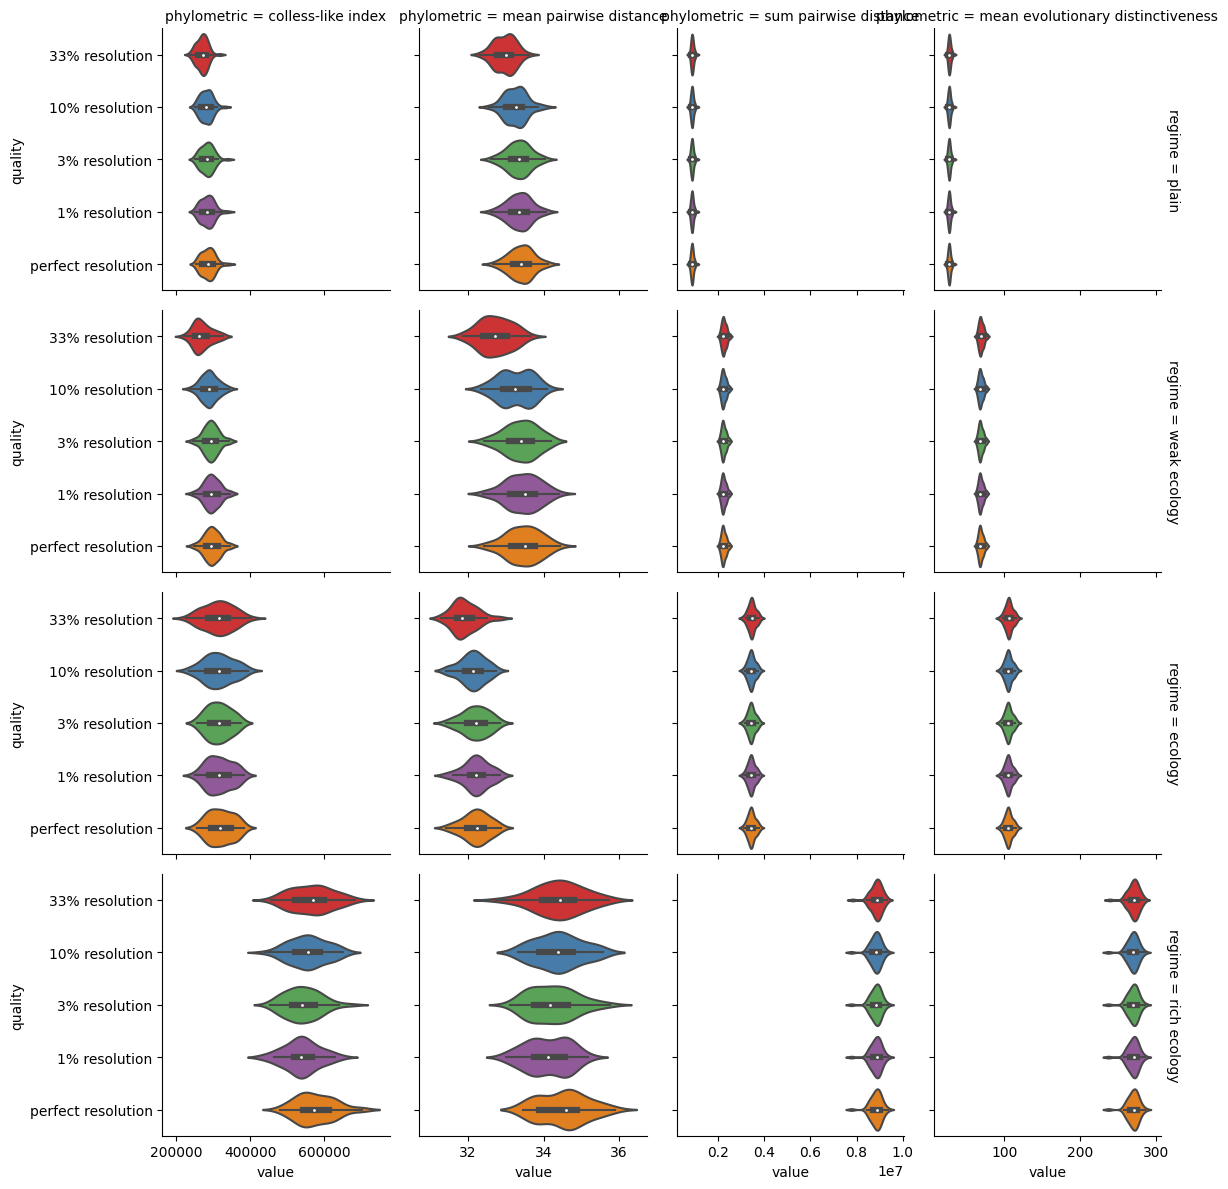

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


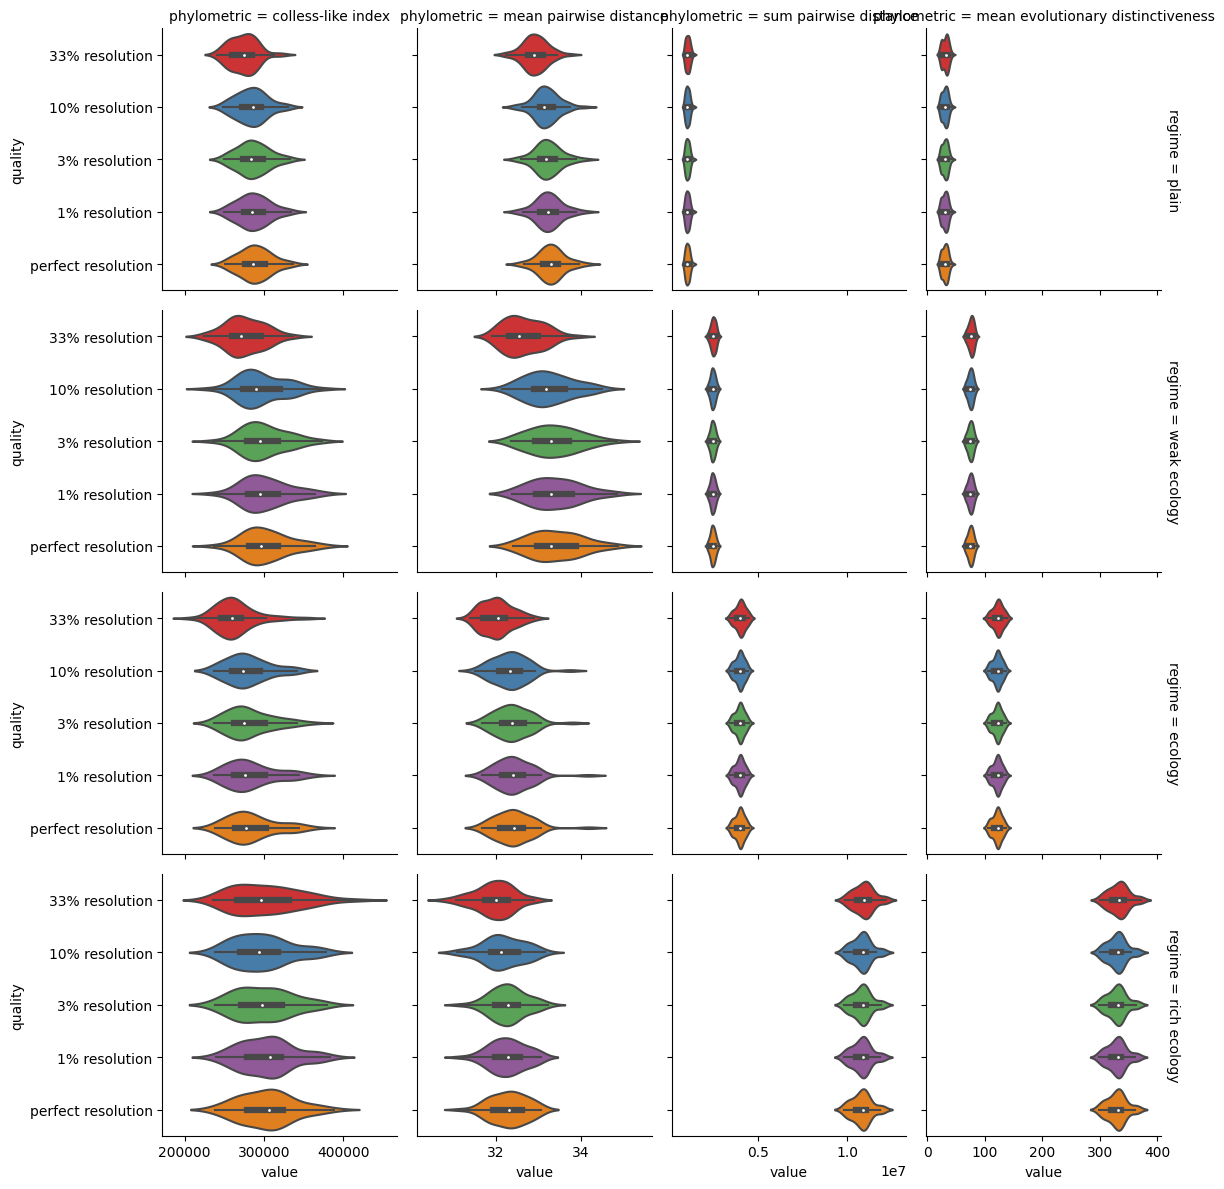

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=violinplot+x=value+y=quality+ext=.png


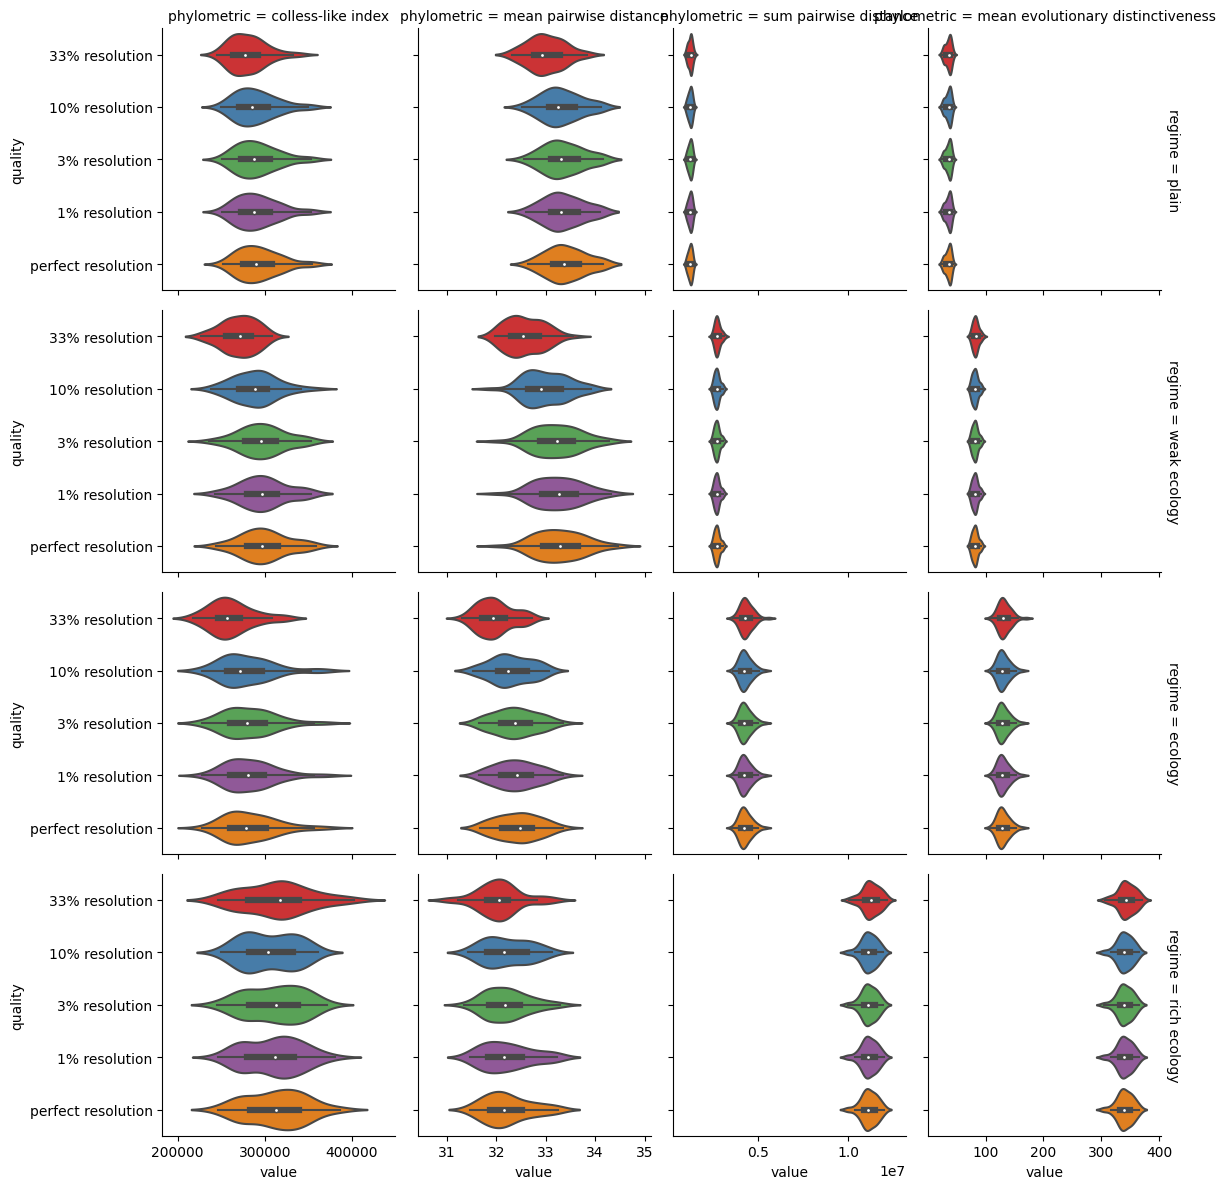

In [27]:
def make_do_plot(plotter):
    def do_plot(data, col, row, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            row=row,
            row_order=[
                "plain",
                "weak ecology",
                "ecology",
                "rich ecology",
            ],
            sharex="col",
            margin_titles=True,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "33% resolution",
                "10% resolution",
                "3% resolution",
                "1% resolution",
                "perfect resolution",
            ],
            palette=sns.color_palette("Set1", 5),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        row="regime",
        x="value",
        y="quality",
        teeplot_outattrs={
            **{
                "nuisance": "spatial-structure",
            },
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
        },
    )


# stats: comparison against perfect


In [28]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        ["regime", *sensitivity_analysis_variables], as_index=False
    ):
        for quality in group_df["quality"].unique():
            if quality == "perfect resolution":
                continue
            kw_result, n = scipy_stats.wilcoxon(
                *zip(
                    *zip(
                        group_df[group_df["quality"] == "perfect resolution"][
                            phylometric
                        ],
                        group_df[group_df["quality"] == quality][phylometric],
                    )
                ),
            ), min(group_df.groupby(["quality"]).count()["a"])
            records.append(
                {
                    **{"quality": quality, "n": n, "phylometric": phylometric},
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(
                        zip(["regime", *sensitivity_analysis_variables], group)
                    ),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime", "phylometric"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-resolutions-allpairs-wilcox-spatial-nuisance+ext=.csv",
        index=False,
    )


quality   n                        phylometric  statistic  \
0    33% resolution  50                 colless-like index      523.0   
1    10% resolution  50                 colless-like index      401.0   
2     1% resolution  50                 colless-like index      434.0   
3     3% resolution  50                 colless-like index      438.0   
4    33% resolution  50  mean evolutionary distinctiveness      514.0   
5    10% resolution  50  mean evolutionary distinctiveness      606.0   
6     1% resolution  50  mean evolutionary distinctiveness      631.0   
7     3% resolution  50  mean evolutionary distinctiveness      579.0   
8    33% resolution  50             mean pairwise distance      560.0   
9    10% resolution  50             mean pairwise distance      517.0   
10    1% resolution  50             mean pairwise distance      466.0   
11    3% resolution  50             mean pairwise distance      460.0   
12   33% resolution  50              sum pairwise distance      514.0   
13   10% resolution  50              sum pairwise distance      606.0   
14    1% resolution  50              sum pairwise distance      631.0   
15    3% resolution  50              sum pairwise distance      579.5   
16   33% resolution  50                 colless-like index      420.0   
17   10% resolution  50                 colless-like index      499.0   
18    3% resolution  50                 colless-like index      513.0   
19    1% resolution  50                 colless-like index      626.0   
20   33% resolution  50  mean evolutionary distinctiveness      556.0   
21   10% resolution  50  mean evolutionary distinctiveness      634.0   
22    3% resolution  50  mean evolutionary distinctiveness      607.0   
23    1% resolution  50  mean evolutionary distinctiveness      613.0   
24   33% resolution  50             mean pairwise distance       68.0   
25   10% resolution  50             mean pairwise distance      438.0   
26    3% resolution  50             mean pairwise distance      531.0   
27    1% resolution  50             mean pairwise distance      579.0   
28   33% resolution  50              sum pairwise distance      556.0   
29   10% resolution  50              sum pairwise distance      634.0   
30    3% resolution  50              sum pairwise distance      607.0   
31    1% resolution  50              sum pairwise distance      613.0   
32   10% resolution  50                 colless-like index        5.0   
33    1% resolution  50                 colless-like index       31.0   
34   33% resolution  50                 colless-like index      224.0   
35    3% resolution  50                 colless-like index        5.0   
36   10% resolution  50  mean evolutionary distinctiveness      511.0   
37    1% resolution  50  mean evolutionary distinctiveness      632.0   
38   33% resolution  50  mean evolutionary distinctiveness      486.0   
39    3% resolution  50  mean evolutionary distinctiveness      563.0   
40   10% resolution  50             mean pairwise distance       73.0   
41    1% resolution  50             mean pairwise distance      105.0   
42   33% resolution  50             mean pairwise distance      481.0   
43    3% resolution  50             mean pairwise distance       58.0   
44   10% resolution  50              sum pairwise distance      511.0   
45    1% resolution  50              sum pairwise distance      632.0   
46   33% resolution  50              sum pairwise distance      486.0   
47    3% resolution  50              sum pairwise distance      563.0   
48    3% resolution  50                 colless-like index      544.0   
49    1% resolution  50                 colless-like index      520.0   
50   10% resolution  50                 colless-like index      489.0   
51   33% resolution  50                 colless-like index      564.0   
52    3% resolution  50  mean evolutionary distinctiveness      612.0   
53    1% resolution  50  mean evolutionary distinctiveness      613.0 

# error signficance heatmap


teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


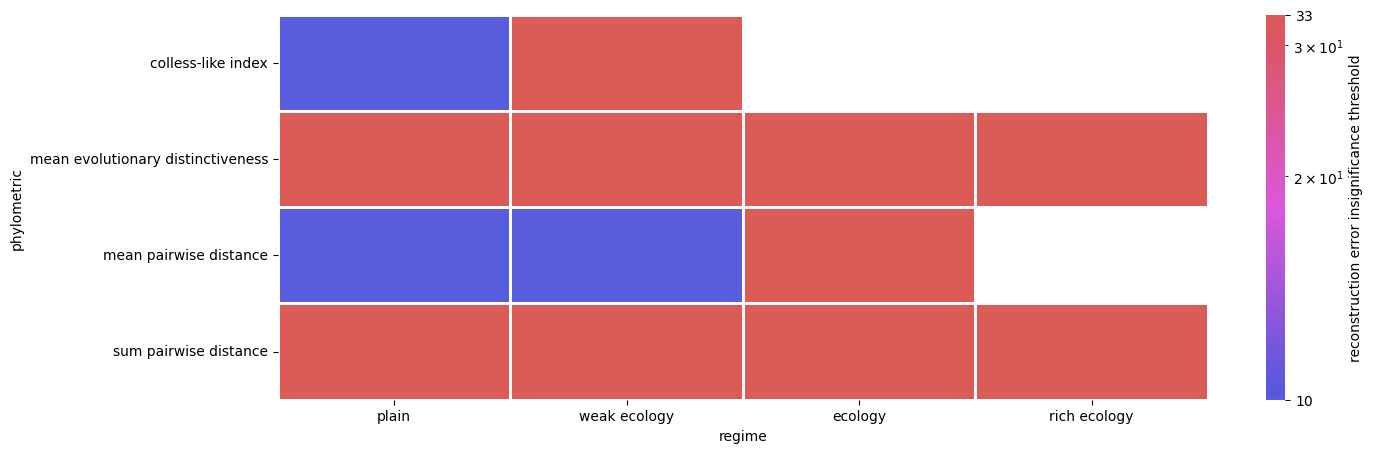

teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


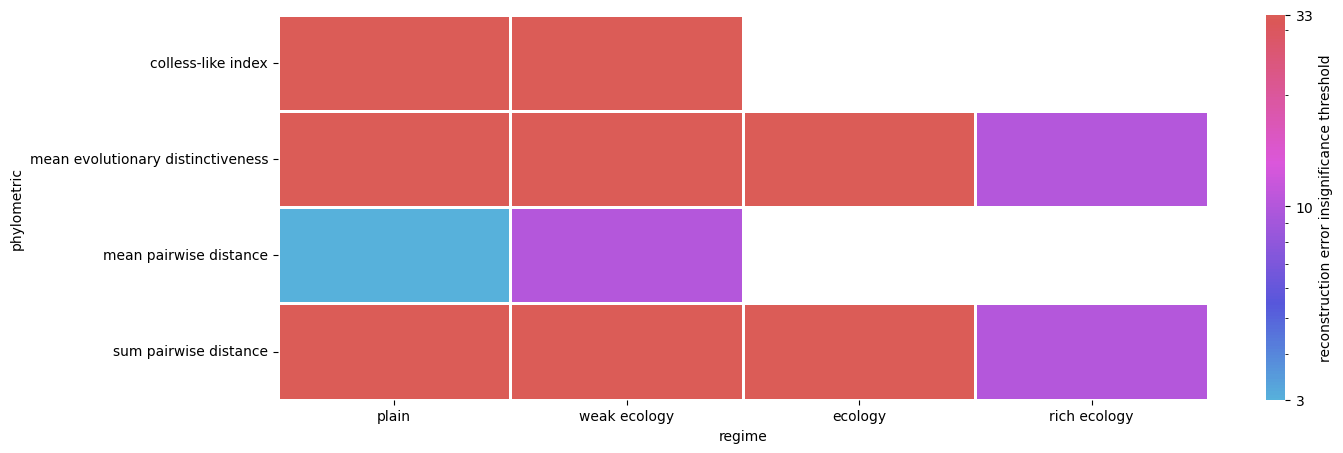

teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


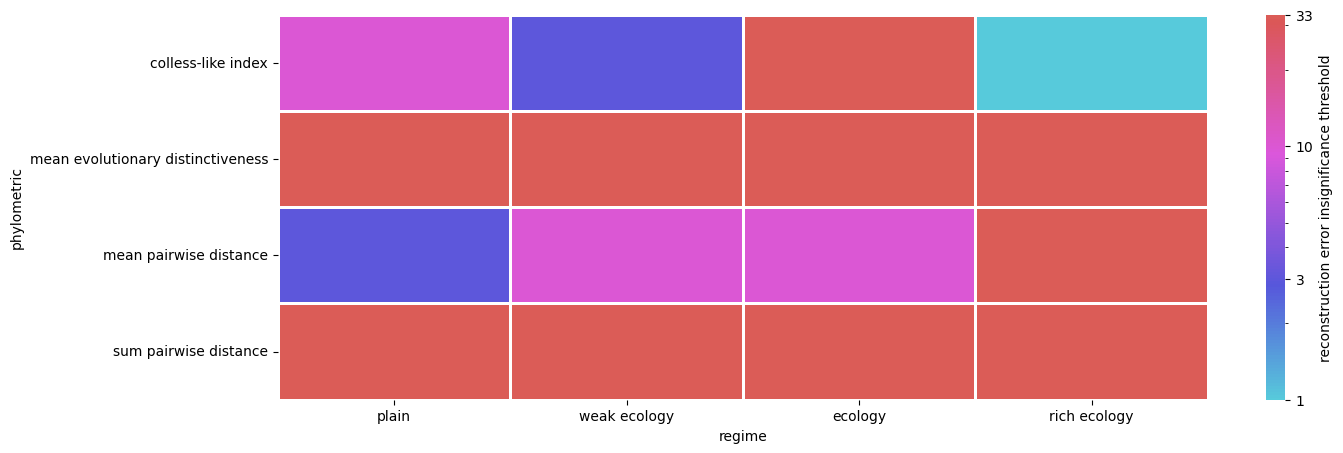

teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


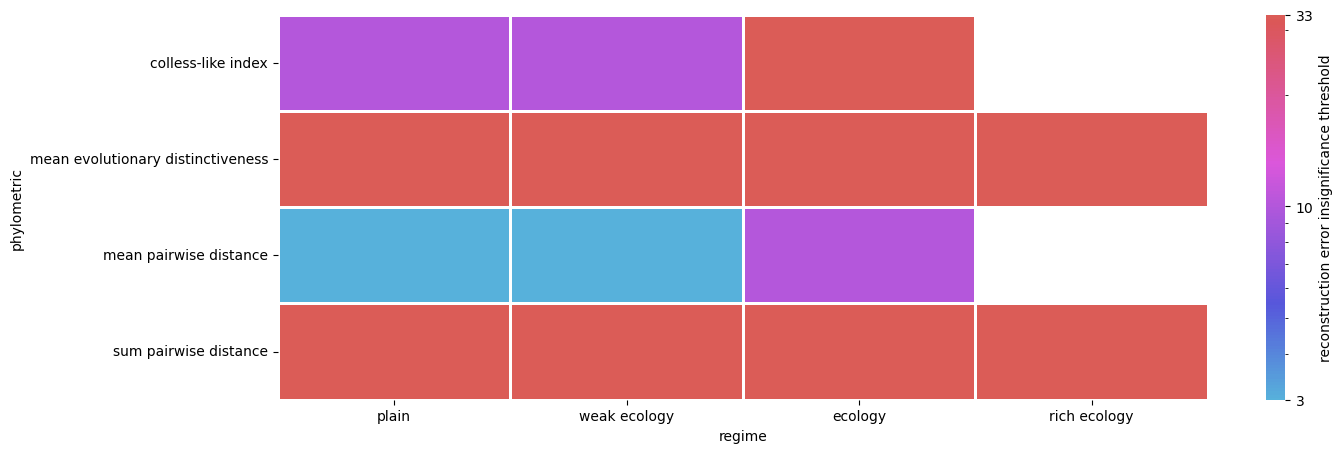

teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


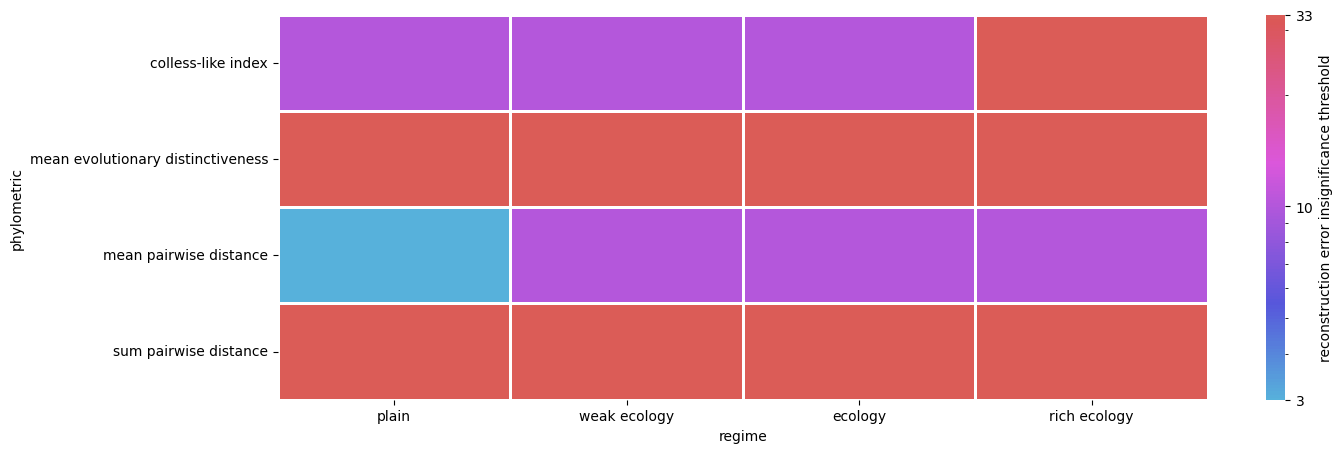

teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png


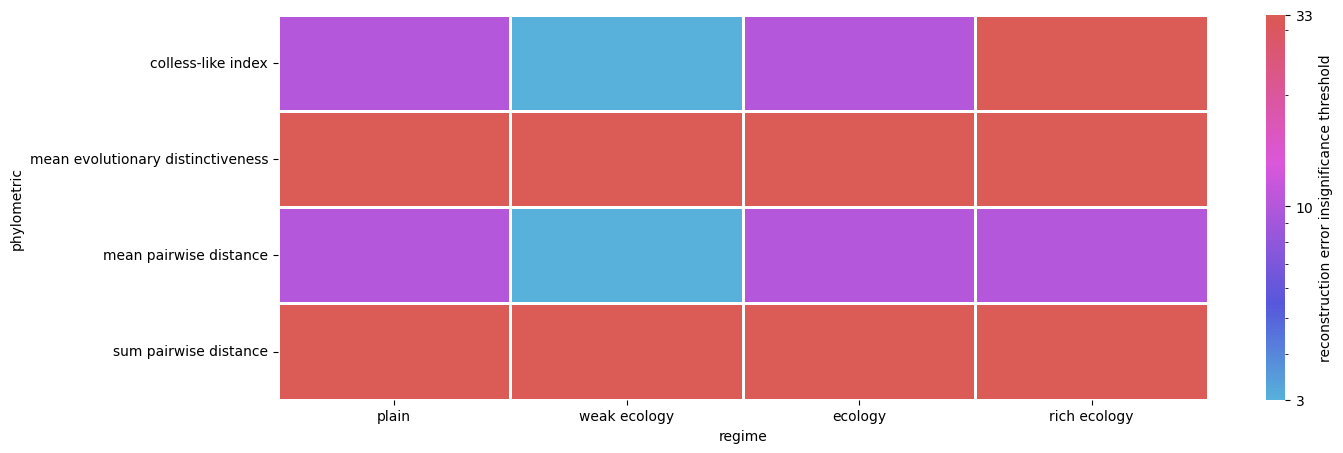

regime                        phylometric  quality threshold  epoch  \
0        ecology                 colless-like index                 10      7   
1        ecology  mean evolutionary distinctiveness                 33      7   
2        ecology             mean pairwise distance                 10      7   
3        ecology              sum pairwise distance                 33      7   
4          plain                 colless-like index                 10      7   
5          plain  mean evolutionary distinctiveness                 33      7   
6          plain             mean pairwise distance                 10      7   
7          plain              sum pairwise distance                 33      7   
8   rich ecology                 colless-like index                 33      7   
9   rich ecology  mean evolutionary distinctiveness                 33      7   
10  rich ecology             mean pairwise distance                 10      7   
11  rich ecology              sum pairwise distance                 33      7   
12  weak ecology                 colless-like index                  3      7   
13  weak ecology  mean evolutionary distinctiveness                 33      7   
14  weak ecology             mean pairwise distance                  3      7   
15  weak ecology              sum pairwise distance                 33      7   

                    mut_distn  
0   np.random.standard_normal  
1   np.random.standard_normal  
2   np.random.standard_normal  
3   np.random.standard_normal  
4   np.random.standard_normal  
5   np.random.standard_normal  
6   np.random.standard_normal  
7   np.random.standard_normal  
8   np.random.standard_normal  
9   np.random.standard_normal  
10  np.random.standard_normal  
11  np.random.standard_normal  
12  np.random.standard_normal  
13  np.random.standard_normal  
14  np.random.standard_normal  
15  np.random.standard_normal

In [29]:
for group, group_df in out_df.groupby(
    sensitivity_analysis_variables, as_index=False
):
    group_df["quality threshold"] = group_df["quality"]
    group_df.loc[group_df["p"] > 0.05, "quality threshold"] = ""
    summarized_df = (
        group_df.groupby(["regime", "phylometric"])
        .agg(
            {
                "quality threshold": lambda subgroup: (
                    np.nan
                    if "1% resolution" in set(subgroup)
                    else 1
                    if "3% resolution" in set(subgroup)
                    else 3
                    if "10% resolution" in set(subgroup)
                    else 10
                    if "33% resolution" in set(subgroup)
                    else 33
                ),
                "epoch": lambda subgroup: ip.pophomogeneous(subgroup),
                "mut_distn": lambda subgroup: ip.pophomogeneous(subgroup),
            }
        )
        .reset_index()
    )

    matrix = summarized_df.pivot(
        index="phylometric",
        columns="regime",
        values="quality threshold",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    fig, ax = plt.subplots(figsize=(15, 5))
    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    tp.tee(
        sns.heatmap,
        matrix,
        linewidths=2,
        norm=mpl.colors.LogNorm(),
        cmap=sns.color_palette("hls", as_cmap=True),
        center=0,
        cbar_kws={
            "label": "reconstruction error insignificance threshold",
            "ticks": [1, 3, 10, 33],
            "format": formatter,
        },
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "nuisance": "spatial-structure",
                "hue": "quality-threshold",
                "x": "regime",
                "y": "phylometric",
            },
        },
    )

summarized_df
